In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 558)
(4629816, 8)
validation
(621056, 558)
(621056, 8)
test
(624904, 558)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:06 - loss: 2.3373 - STD: 0.0766 - MAE: 0.2206

  5/463 [..............................] - ETA: 6s - loss: 2.1371 - STD: 0.0500 - MAE: 0.2176   

  9/463 [..............................] - ETA: 6s - loss: 2.1195 - STD: 0.0547 - MAE: 0.2166

 13/463 [..............................] - ETA: 6s - loss: 2.1000 - STD: 0.0499 - MAE: 0.2165

 17/463 [>.............................] - ETA: 5s - loss: 2.0900 - STD: 0.0448 - MAE: 0.2167

 21/463 [>.............................] - ETA: 5s - loss: 2.0836 - STD: 0.0406 - MAE: 0.2168

 25/463 [>.............................] - ETA: 5s - loss: 2.0778 - STD: 0.0394 - MAE: 0.2168

 30/463 [>.............................] - ETA: 5s - loss: 2.0714 - STD: 0.0394 - MAE: 0.2166

 35/463 [=>............................] - ETA: 5s - loss: 2.0640 - STD: 0.0388 - MAE: 0.2164

 39/463 [=>............................] - ETA: 5s - loss: 2.0561 - STD: 0.0382 - MAE: 0.2163

 43/463 [=>............................] - ETA: 5s - loss: 2.0458 - STD: 0.0384 - MAE: 0.2159

 48/463 [==>...........................] - ETA: 5s - loss: 2.0299 - STD: 0.0404 - MAE: 0.2153

 53/463 [==>...........................] - ETA: 5s - loss: 2.0122 - STD: 0.0435 - MAE: 0.2144

 57/463 [==>...........................] - ETA: 5s - loss: 1.9977 - STD: 0.0460 - MAE: 0.2137

 62/463 [===>..........................] - ETA: 5s - loss: 1.9778 - STD: 0.0488 - MAE: 0.2128

 66/463 [===>..........................] - ETA: 5s - loss: 1.9599 - STD: 0.0513 - MAE: 0.2119

 70/463 [===>..........................] - ETA: 5s - loss: 1.9413 - STD: 0.0541 - MAE: 0.2109

 75/463 [===>..........................] - ETA: 4s - loss: 1.9186 - STD: 0.0578 - MAE: 0.2096

 79/463 [====>.........................] - ETA: 4s - loss: 1.9004 - STD: 0.0606 - MAE: 0.2086

 83/463 [====>.........................] - ETA: 4s - loss: 1.8828 - STD: 0.0634 - MAE: 0.2076

 87/463 [====>.........................] - ETA: 4s - loss: 1.8659 - STD: 0.0661 - MAE: 0.2065

 91/463 [====>.........................] - ETA: 4s - loss: 1.8492 - STD: 0.0688 - MAE: 0.2055

 96/463 [=====>........................] - ETA: 4s - loss: 1.8293 - STD: 0.0720 - MAE: 0.2042

101/463 [=====>........................] - ETA: 4s - loss: 1.8101 - STD: 0.0751 - MAE: 0.2030

105/463 [=====>........................] - ETA: 4s - loss: 1.7954 - STD: 0.0775 - MAE: 0.2020

109/463 [======>.......................] - ETA: 4s - loss: 1.7813 - STD: 0.0798 - MAE: 0.2011

113/463 [======>.......................] - ETA: 4s - loss: 1.7676 - STD: 0.0821 - MAE: 0.2002

117/463 [======>.......................] - ETA: 4s - loss: 1.7544 - STD: 0.0842 - MAE: 0.1992

122/463 [======>.......................] - ETA: 4s - loss: 1.7386 - STD: 0.0868 - MAE: 0.1981

127/463 [=======>......................] - ETA: 4s - loss: 1.7233 - STD: 0.0893 - MAE: 0.1971

131/463 [=======>......................] - ETA: 4s - loss: 1.7118 - STD: 0.0912 - MAE: 0.1962

136/463 [=======>......................] - ETA: 4s - loss: 1.6978 - STD: 0.0935 - MAE: 0.1952

140/463 [========>.....................] - ETA: 4s - loss: 1.6872 - STD: 0.0952 - MAE: 0.1944

145/463 [========>.....................] - ETA: 4s - loss: 1.6743 - STD: 0.0974 - MAE: 0.1934

150/463 [========>.....................] - ETA: 3s - loss: 1.6621 - STD: 0.0994 - MAE: 0.1925

155/463 [=========>....................] - ETA: 3s - loss: 1.6506 - STD: 0.1014 - MAE: 0.1916

160/463 [=========>....................] - ETA: 3s - loss: 1.6395 - STD: 0.1032 - MAE: 0.1908

164/463 [=========>....................] - ETA: 3s - loss: 1.6311 - STD: 0.1046 - MAE: 0.1901

168/463 [=========>....................] - ETA: 3s - loss: 1.6230 - STD: 0.1060 - MAE: 0.1895

173/463 [==========>...................] - ETA: 3s - loss: 1.6133 - STD: 0.1077 - MAE: 0.1887

178/463 [==========>...................] - ETA: 3s - loss: 1.6041 - STD: 0.1093 - MAE: 0.1880

183/463 [==========>...................] - ETA: 3s - loss: 1.5952 - STD: 0.1108 - MAE: 0.1873

187/463 [===========>..................] - ETA: 3s - loss: 1.5882 - STD: 0.1119 - MAE: 0.1867

191/463 [===========>..................] - ETA: 3s - loss: 1.5814 - STD: 0.1131 - MAE: 0.1862

196/463 [===========>..................] - ETA: 3s - loss: 1.5733 - STD: 0.1145 - MAE: 0.1855

200/463 [===========>..................] - ETA: 3s - loss: 1.5670 - STD: 0.1155 - MAE: 0.1850

205/463 [============>.................] - ETA: 3s - loss: 1.5596 - STD: 0.1168 - MAE: 0.1844

209/463 [============>.................] - ETA: 3s - loss: 1.5537 - STD: 0.1178 - MAE: 0.1840

213/463 [============>.................] - ETA: 3s - loss: 1.5481 - STD: 0.1188 - MAE: 0.1835

217/463 [=============>................] - ETA: 3s - loss: 1.5426 - STD: 0.1197 - MAE: 0.1830

222/463 [=============>................] - ETA: 3s - loss: 1.5360 - STD: 0.1209 - MAE: 0.1825

227/463 [=============>................] - ETA: 2s - loss: 1.5294 - STD: 0.1220 - MAE: 0.1820

231/463 [=============>................] - ETA: 2s - loss: 1.5244 - STD: 0.1228 - MAE: 0.1815

236/463 [==============>...............] - ETA: 2s - loss: 1.5183 - STD: 0.1239 - MAE: 0.1810

240/463 [==============>...............] - ETA: 2s - loss: 1.5135 - STD: 0.1247 - MAE: 0.1806

244/463 [==============>...............] - ETA: 2s - loss: 1.5087 - STD: 0.1255 - MAE: 0.1802

248/463 [===============>..............] - ETA: 2s - loss: 1.5042 - STD: 0.1263 - MAE: 0.1799

253/463 [===============>..............] - ETA: 2s - loss: 1.4988 - STD: 0.1272 - MAE: 0.1794

258/463 [===============>..............] - ETA: 2s - loss: 1.4934 - STD: 0.1281 - MAE: 0.1789

262/463 [===============>..............] - ETA: 2s - loss: 1.4892 - STD: 0.1288 - MAE: 0.1786

266/463 [================>.............] - ETA: 2s - loss: 1.4851 - STD: 0.1295 - MAE: 0.1782

270/463 [================>.............] - ETA: 2s - loss: 1.4811 - STD: 0.1302 - MAE: 0.1779

274/463 [================>.............] - ETA: 2s - loss: 1.4772 - STD: 0.1309 - MAE: 0.1775

278/463 [=================>............] - ETA: 2s - loss: 1.4734 - STD: 0.1315 - MAE: 0.1772

283/463 [=================>............] - ETA: 2s - loss: 1.4688 - STD: 0.1323 - MAE: 0.1768

288/463 [=================>............] - ETA: 2s - loss: 1.4644 - STD: 0.1331 - MAE: 0.1765

292/463 [=================>............] - ETA: 2s - loss: 1.4610 - STD: 0.1337 - MAE: 0.1762

296/463 [==================>...........] - ETA: 2s - loss: 1.4576 - STD: 0.1343 - MAE: 0.1759

301/463 [==================>...........] - ETA: 2s - loss: 1.4535 - STD: 0.1350 - MAE: 0.1755

305/463 [==================>...........] - ETA: 1s - loss: 1.4502 - STD: 0.1356 - MAE: 0.1752

310/463 [===================>..........] - ETA: 1s - loss: 1.4463 - STD: 0.1363 - MAE: 0.1749

314/463 [===================>..........] - ETA: 1s - loss: 1.4433 - STD: 0.1368 - MAE: 0.1746

318/463 [===================>..........] - ETA: 1s - loss: 1.4402 - STD: 0.1373 - MAE: 0.1743

323/463 [===================>..........] - ETA: 1s - loss: 1.4365 - STD: 0.1380 - MAE: 0.1740

328/463 [====================>.........] - ETA: 1s - loss: 1.4329 - STD: 0.1386 - MAE: 0.1737

332/463 [====================>.........] - ETA: 1s - loss: 1.4301 - STD: 0.1391 - MAE: 0.1735

336/463 [====================>.........] - ETA: 1s - loss: 1.4272 - STD: 0.1396 - MAE: 0.1732

340/463 [=====================>........] - ETA: 1s - loss: 1.4245 - STD: 0.1401 - MAE: 0.1730

344/463 [=====================>........] - ETA: 1s - loss: 1.4218 - STD: 0.1405 - MAE: 0.1727

348/463 [=====================>........] - ETA: 1s - loss: 1.4191 - STD: 0.1410 - MAE: 0.1725

352/463 [=====================>........] - ETA: 1s - loss: 1.4165 - STD: 0.1414 - MAE: 0.1722

356/463 [======================>.......] - ETA: 1s - loss: 1.4139 - STD: 0.1419 - MAE: 0.1720

360/463 [======================>.......] - ETA: 1s - loss: 1.4114 - STD: 0.1423 - MAE: 0.1718

364/463 [======================>.......] - ETA: 1s - loss: 1.4088 - STD: 0.1427 - MAE: 0.1716

368/463 [======================>.......] - ETA: 1s - loss: 1.4063 - STD: 0.1432 - MAE: 0.1713

373/463 [=======================>......] - ETA: 1s - loss: 1.4034 - STD: 0.1437 - MAE: 0.1711

378/463 [=======================>......] - ETA: 1s - loss: 1.4004 - STD: 0.1442 - MAE: 0.1708

383/463 [=======================>......] - ETA: 1s - loss: 1.3975 - STD: 0.1447 - MAE: 0.1706

387/463 [========================>.....] - ETA: 0s - loss: 1.3952 - STD: 0.1451 - MAE: 0.1703

391/463 [========================>.....] - ETA: 0s - loss: 1.3930 - STD: 0.1455 - MAE: 0.1701

396/463 [========================>.....] - ETA: 0s - loss: 1.3901 - STD: 0.1460 - MAE: 0.1699

400/463 [========================>.....] - ETA: 0s - loss: 1.3880 - STD: 0.1463 - MAE: 0.1697

404/463 [=========================>....] - ETA: 0s - loss: 1.3859 - STD: 0.1467 - MAE: 0.1695

408/463 [=========================>....] - ETA: 0s - loss: 1.3838 - STD: 0.1471 - MAE: 0.1693

412/463 [=========================>....] - ETA: 0s - loss: 1.3817 - STD: 0.1474 - MAE: 0.1691

416/463 [=========================>....] - ETA: 0s - loss: 1.3797 - STD: 0.1478 - MAE: 0.1690

420/463 [==========================>...] - ETA: 0s - loss: 1.3777 - STD: 0.1481 - MAE: 0.1688

425/463 [==========================>...] - ETA: 0s - loss: 1.3751 - STD: 0.1485 - MAE: 0.1685

429/463 [==========================>...] - ETA: 0s - loss: 1.3731 - STD: 0.1489 - MAE: 0.1684

434/463 [===========================>..] - ETA: 0s - loss: 1.3706 - STD: 0.1493 - MAE: 0.1681

438/463 [===========================>..] - ETA: 0s - loss: 1.3687 - STD: 0.1496 - MAE: 0.1680

441/463 [===========================>..] - ETA: 0s - loss: 1.3672 - STD: 0.1499 - MAE: 0.1678

445/463 [===========================>..] - ETA: 0s - loss: 1.3653 - STD: 0.1502 - MAE: 0.1677

449/463 [============================>.] - ETA: 0s - loss: 1.3634 - STD: 0.1505 - MAE: 0.1675

453/463 [============================>.] - ETA: 0s - loss: 1.3616 - STD: 0.1508 - MAE: 0.1673

457/463 [============================>.] - ETA: 0s - loss: 1.3598 - STD: 0.1511 - MAE: 0.1672

462/463 [============================>.] - ETA: 0s - loss: 1.3576 - STD: 0.1515 - MAE: 0.1670

463/463 [==============================] - 9s 17ms/step - loss: 1.3572 - STD: 0.1516 - MAE: 0.1669 - val_loss: 1.2243 - val_STD: 0.1816 - val_MAE: 0.1532


Epoch 2/10000


  1/463 [..............................] - ETA: 17s - loss: 1.1689 - STD: 0.1866 - MAE: 0.1489

  6/463 [..............................] - ETA: 5s - loss: 1.1524 - STD: 0.1864 - MAE: 0.1480 

 10/463 [..............................] - ETA: 5s - loss: 1.1490 - STD: 0.1865 - MAE: 0.1478

 15/463 [..............................] - ETA: 5s - loss: 1.1529 - STD: 0.1865 - MAE: 0.1481

 19/463 [>.............................] - ETA: 5s - loss: 1.1526 - STD: 0.1866 - MAE: 0.1480

 23/463 [>.............................] - ETA: 5s - loss: 1.1522 - STD: 0.1866 - MAE: 0.1480

 27/463 [>.............................] - ETA: 5s - loss: 1.1507 - STD: 0.1866 - MAE: 0.1479

 31/463 [=>............................] - ETA: 5s - loss: 1.1499 - STD: 0.1867 - MAE: 0.1478

 36/463 [=>............................] - ETA: 5s - loss: 1.1491 - STD: 0.1866 - MAE: 0.1478

 40/463 [=>............................] - ETA: 5s - loss: 1.1472 - STD: 0.1868 - MAE: 0.1476

 44/463 [=>............................] - ETA: 5s - loss: 1.1465 - STD: 0.1870 - MAE: 0.1475

 48/463 [==>...........................] - ETA: 5s - loss: 1.1453 - STD: 0.1870 - MAE: 0.1475

 52/463 [==>...........................] - ETA: 5s - loss: 1.1444 - STD: 0.1872 - MAE: 0.1473

 56/463 [==>...........................] - ETA: 5s - loss: 1.1436 - STD: 0.1872 - MAE: 0.1473

 60/463 [==>...........................] - ETA: 5s - loss: 1.1430 - STD: 0.1873 - MAE: 0.1472

 64/463 [===>..........................] - ETA: 5s - loss: 1.1421 - STD: 0.1874 - MAE: 0.1471

 68/463 [===>..........................] - ETA: 5s - loss: 1.1406 - STD: 0.1875 - MAE: 0.1470

 72/463 [===>..........................] - ETA: 5s - loss: 1.1394 - STD: 0.1876 - MAE: 0.1469

 77/463 [===>..........................] - ETA: 4s - loss: 1.1389 - STD: 0.1877 - MAE: 0.1468

 81/463 [====>.........................] - ETA: 4s - loss: 1.1384 - STD: 0.1878 - MAE: 0.1468

 85/463 [====>.........................] - ETA: 4s - loss: 1.1384 - STD: 0.1880 - MAE: 0.1467

 89/463 [====>.........................] - ETA: 4s - loss: 1.1379 - STD: 0.1880 - MAE: 0.1467

 93/463 [=====>........................] - ETA: 4s - loss: 1.1380 - STD: 0.1881 - MAE: 0.1466

 98/463 [=====>........................] - ETA: 4s - loss: 1.1376 - STD: 0.1882 - MAE: 0.1466

102/463 [=====>........................] - ETA: 4s - loss: 1.1369 - STD: 0.1883 - MAE: 0.1465

106/463 [=====>........................] - ETA: 4s - loss: 1.1360 - STD: 0.1884 - MAE: 0.1464

111/463 [======>.......................] - ETA: 4s - loss: 1.1358 - STD: 0.1885 - MAE: 0.1464

115/463 [======>.......................] - ETA: 4s - loss: 1.1350 - STD: 0.1886 - MAE: 0.1463

120/463 [======>.......................] - ETA: 4s - loss: 1.1343 - STD: 0.1887 - MAE: 0.1462

124/463 [=======>......................] - ETA: 4s - loss: 1.1339 - STD: 0.1888 - MAE: 0.1462

128/463 [=======>......................] - ETA: 4s - loss: 1.1335 - STD: 0.1888 - MAE: 0.1461

133/463 [=======>......................] - ETA: 4s - loss: 1.1334 - STD: 0.1890 - MAE: 0.1461

137/463 [=======>......................] - ETA: 4s - loss: 1.1329 - STD: 0.1890 - MAE: 0.1460

141/463 [========>.....................] - ETA: 4s - loss: 1.1327 - STD: 0.1891 - MAE: 0.1460

146/463 [========>.....................] - ETA: 4s - loss: 1.1324 - STD: 0.1892 - MAE: 0.1459

151/463 [========>.....................] - ETA: 3s - loss: 1.1316 - STD: 0.1893 - MAE: 0.1458

155/463 [=========>....................] - ETA: 3s - loss: 1.1308 - STD: 0.1893 - MAE: 0.1458

159/463 [=========>....................] - ETA: 3s - loss: 1.1301 - STD: 0.1894 - MAE: 0.1457

163/463 [=========>....................] - ETA: 3s - loss: 1.1296 - STD: 0.1895 - MAE: 0.1456

167/463 [=========>....................] - ETA: 3s - loss: 1.1291 - STD: 0.1896 - MAE: 0.1456

172/463 [==========>...................] - ETA: 3s - loss: 1.1285 - STD: 0.1897 - MAE: 0.1455

176/463 [==========>...................] - ETA: 3s - loss: 1.1280 - STD: 0.1898 - MAE: 0.1454

181/463 [==========>...................] - ETA: 3s - loss: 1.1274 - STD: 0.1898 - MAE: 0.1454

185/463 [==========>...................] - ETA: 3s - loss: 1.1270 - STD: 0.1899 - MAE: 0.1453

189/463 [===========>..................] - ETA: 3s - loss: 1.1264 - STD: 0.1900 - MAE: 0.1453

193/463 [===========>..................] - ETA: 3s - loss: 1.1258 - STD: 0.1901 - MAE: 0.1452

197/463 [===========>..................] - ETA: 3s - loss: 1.1252 - STD: 0.1901 - MAE: 0.1451

201/463 [============>.................] - ETA: 3s - loss: 1.1247 - STD: 0.1902 - MAE: 0.1451

206/463 [============>.................] - ETA: 3s - loss: 1.1243 - STD: 0.1903 - MAE: 0.1450

210/463 [============>.................] - ETA: 3s - loss: 1.1239 - STD: 0.1904 - MAE: 0.1450

214/463 [============>.................] - ETA: 3s - loss: 1.1235 - STD: 0.1905 - MAE: 0.1449

218/463 [=============>................] - ETA: 3s - loss: 1.1231 - STD: 0.1905 - MAE: 0.1449

222/463 [=============>................] - ETA: 3s - loss: 1.1225 - STD: 0.1906 - MAE: 0.1448

226/463 [=============>................] - ETA: 3s - loss: 1.1218 - STD: 0.1907 - MAE: 0.1447

230/463 [=============>................] - ETA: 2s - loss: 1.1210 - STD: 0.1907 - MAE: 0.1447

235/463 [==============>...............] - ETA: 2s - loss: 1.1204 - STD: 0.1909 - MAE: 0.1446

239/463 [==============>...............] - ETA: 2s - loss: 1.1198 - STD: 0.1909 - MAE: 0.1445

244/463 [==============>...............] - ETA: 2s - loss: 1.1192 - STD: 0.1910 - MAE: 0.1444

248/463 [===============>..............] - ETA: 2s - loss: 1.1187 - STD: 0.1911 - MAE: 0.1444

252/463 [===============>..............] - ETA: 2s - loss: 1.1180 - STD: 0.1912 - MAE: 0.1443

256/463 [===============>..............] - ETA: 2s - loss: 1.1176 - STD: 0.1913 - MAE: 0.1443

261/463 [===============>..............] - ETA: 2s - loss: 1.1169 - STD: 0.1914 - MAE: 0.1442

265/463 [================>.............] - ETA: 2s - loss: 1.1165 - STD: 0.1914 - MAE: 0.1441

270/463 [================>.............] - ETA: 2s - loss: 1.1160 - STD: 0.1915 - MAE: 0.1441

274/463 [================>.............] - ETA: 2s - loss: 1.1156 - STD: 0.1916 - MAE: 0.1440

278/463 [=================>............] - ETA: 2s - loss: 1.1153 - STD: 0.1917 - MAE: 0.1440

282/463 [=================>............] - ETA: 2s - loss: 1.1148 - STD: 0.1917 - MAE: 0.1439

287/463 [=================>............] - ETA: 2s - loss: 1.1141 - STD: 0.1918 - MAE: 0.1439

291/463 [=================>............] - ETA: 2s - loss: 1.1137 - STD: 0.1919 - MAE: 0.1438

295/463 [==================>...........] - ETA: 2s - loss: 1.1133 - STD: 0.1919 - MAE: 0.1438

299/463 [==================>...........] - ETA: 2s - loss: 1.1129 - STD: 0.1920 - MAE: 0.1437

303/463 [==================>...........] - ETA: 2s - loss: 1.1125 - STD: 0.1921 - MAE: 0.1437

307/463 [==================>...........] - ETA: 1s - loss: 1.1122 - STD: 0.1921 - MAE: 0.1436

311/463 [===================>..........] - ETA: 1s - loss: 1.1118 - STD: 0.1922 - MAE: 0.1436

315/463 [===================>..........] - ETA: 1s - loss: 1.1114 - STD: 0.1923 - MAE: 0.1435

319/463 [===================>..........] - ETA: 1s - loss: 1.1110 - STD: 0.1923 - MAE: 0.1435

323/463 [===================>..........] - ETA: 1s - loss: 1.1107 - STD: 0.1924 - MAE: 0.1434

327/463 [====================>.........] - ETA: 1s - loss: 1.1103 - STD: 0.1925 - MAE: 0.1434

331/463 [====================>.........] - ETA: 1s - loss: 1.1098 - STD: 0.1925 - MAE: 0.1434

335/463 [====================>.........] - ETA: 1s - loss: 1.1093 - STD: 0.1926 - MAE: 0.1433

340/463 [=====================>........] - ETA: 1s - loss: 1.1087 - STD: 0.1927 - MAE: 0.1432

344/463 [=====================>........] - ETA: 1s - loss: 1.1082 - STD: 0.1927 - MAE: 0.1432

348/463 [=====================>........] - ETA: 1s - loss: 1.1077 - STD: 0.1928 - MAE: 0.1431

352/463 [=====================>........] - ETA: 1s - loss: 1.1072 - STD: 0.1928 - MAE: 0.1431

356/463 [======================>.......] - ETA: 1s - loss: 1.1068 - STD: 0.1929 - MAE: 0.1430

360/463 [======================>.......] - ETA: 1s - loss: 1.1064 - STD: 0.1930 - MAE: 0.1430

364/463 [======================>.......] - ETA: 1s - loss: 1.1061 - STD: 0.1930 - MAE: 0.1429

368/463 [======================>.......] - ETA: 1s - loss: 1.1058 - STD: 0.1931 - MAE: 0.1429

372/463 [=======================>......] - ETA: 1s - loss: 1.1054 - STD: 0.1932 - MAE: 0.1429

376/463 [=======================>......] - ETA: 1s - loss: 1.1050 - STD: 0.1932 - MAE: 0.1428

380/463 [=======================>......] - ETA: 1s - loss: 1.1047 - STD: 0.1933 - MAE: 0.1428

384/463 [=======================>......] - ETA: 1s - loss: 1.1045 - STD: 0.1933 - MAE: 0.1427

388/463 [========================>.....] - ETA: 0s - loss: 1.1044 - STD: 0.1934 - MAE: 0.1427

392/463 [========================>.....] - ETA: 0s - loss: 1.1041 - STD: 0.1934 - MAE: 0.1427

396/463 [========================>.....] - ETA: 0s - loss: 1.1037 - STD: 0.1935 - MAE: 0.1426

400/463 [========================>.....] - ETA: 0s - loss: 1.1034 - STD: 0.1936 - MAE: 0.1426

404/463 [=========================>....] - ETA: 0s - loss: 1.1030 - STD: 0.1936 - MAE: 0.1426

408/463 [=========================>....] - ETA: 0s - loss: 1.1026 - STD: 0.1937 - MAE: 0.1425

413/463 [=========================>....] - ETA: 0s - loss: 1.1020 - STD: 0.1937 - MAE: 0.1424

417/463 [==========================>...] - ETA: 0s - loss: 1.1016 - STD: 0.1938 - MAE: 0.1424

422/463 [==========================>...] - ETA: 0s - loss: 1.1010 - STD: 0.1938 - MAE: 0.1423

426/463 [==========================>...] - ETA: 0s - loss: 1.1005 - STD: 0.1939 - MAE: 0.1423

430/463 [==========================>...] - ETA: 0s - loss: 1.1001 - STD: 0.1939 - MAE: 0.1423

434/463 [===========================>..] - ETA: 0s - loss: 1.0996 - STD: 0.1940 - MAE: 0.1422

439/463 [===========================>..] - ETA: 0s - loss: 1.0991 - STD: 0.1941 - MAE: 0.1421

444/463 [===========================>..] - ETA: 0s - loss: 1.0984 - STD: 0.1941 - MAE: 0.1421

449/463 [============================>.] - ETA: 0s - loss: 1.0979 - STD: 0.1942 - MAE: 0.1420

453/463 [============================>.] - ETA: 0s - loss: 1.0975 - STD: 0.1943 - MAE: 0.1420

457/463 [============================>.] - ETA: 0s - loss: 1.0970 - STD: 0.1943 - MAE: 0.1419

462/463 [============================>.] - ETA: 0s - loss: 1.0964 - STD: 0.1944 - MAE: 0.1419

463/463 [==============================] - 7s 14ms/step - loss: 1.0964 - STD: 0.1944 - MAE: 0.1419 - val_loss: 1.2196 - val_STD: 0.1962 - val_MAE: 0.1462


Epoch 3/10000


  1/463 [..............................] - ETA: 19s - loss: 1.0759 - STD: 0.2005 - MAE: 0.1383

  5/463 [..............................] - ETA: 6s - loss: 1.0543 - STD: 0.2010 - MAE: 0.1370 

  9/463 [..............................] - ETA: 6s - loss: 1.0614 - STD: 0.2019 - MAE: 0.1370

 13/463 [..............................] - ETA: 6s - loss: 1.0654 - STD: 0.2017 - MAE: 0.1373

 17/463 [>.............................] - ETA: 6s - loss: 1.0656 - STD: 0.2015 - MAE: 0.1373

 21/463 [>.............................] - ETA: 6s - loss: 1.0648 - STD: 0.2017 - MAE: 0.1372

 25/463 [>.............................] - ETA: 6s - loss: 1.0637 - STD: 0.2019 - MAE: 0.1371

 29/463 [>.............................] - ETA: 6s - loss: 1.0618 - STD: 0.2017 - MAE: 0.1370

 33/463 [=>............................] - ETA: 6s - loss: 1.0602 - STD: 0.2017 - MAE: 0.1369

 37/463 [=>............................] - ETA: 6s - loss: 1.0584 - STD: 0.2017 - MAE: 0.1369

 41/463 [=>............................] - ETA: 5s - loss: 1.0565 - STD: 0.2017 - MAE: 0.1368

 45/463 [=>............................] - ETA: 5s - loss: 1.0551 - STD: 0.2017 - MAE: 0.1367

 49/463 [==>...........................] - ETA: 5s - loss: 1.0537 - STD: 0.2017 - MAE: 0.1366

 53/463 [==>...........................] - ETA: 5s - loss: 1.0526 - STD: 0.2017 - MAE: 0.1366

 57/463 [==>...........................] - ETA: 5s - loss: 1.0510 - STD: 0.2017 - MAE: 0.1365

 61/463 [==>...........................] - ETA: 5s - loss: 1.0501 - STD: 0.2017 - MAE: 0.1364

 65/463 [===>..........................] - ETA: 5s - loss: 1.0490 - STD: 0.2018 - MAE: 0.1363

 69/463 [===>..........................] - ETA: 5s - loss: 1.0479 - STD: 0.2019 - MAE: 0.1362

 73/463 [===>..........................] - ETA: 5s - loss: 1.0476 - STD: 0.2019 - MAE: 0.1362

 77/463 [===>..........................] - ETA: 5s - loss: 1.0472 - STD: 0.2019 - MAE: 0.1361

 81/463 [====>.........................] - ETA: 5s - loss: 1.0461 - STD: 0.2020 - MAE: 0.1361

 85/463 [====>.........................] - ETA: 5s - loss: 1.0457 - STD: 0.2021 - MAE: 0.1360

 89/463 [====>.........................] - ETA: 5s - loss: 1.0458 - STD: 0.2022 - MAE: 0.1360

 94/463 [=====>........................] - ETA: 5s - loss: 1.0456 - STD: 0.2022 - MAE: 0.1359

 98/463 [=====>........................] - ETA: 5s - loss: 1.0453 - STD: 0.2022 - MAE: 0.1359

102/463 [=====>........................] - ETA: 5s - loss: 1.0448 - STD: 0.2023 - MAE: 0.1358

106/463 [=====>........................] - ETA: 4s - loss: 1.0443 - STD: 0.2023 - MAE: 0.1358

110/463 [======>.......................] - ETA: 4s - loss: 1.0437 - STD: 0.2023 - MAE: 0.1358

114/463 [======>.......................] - ETA: 4s - loss: 1.0432 - STD: 0.2024 - MAE: 0.1357

118/463 [======>.......................] - ETA: 4s - loss: 1.0433 - STD: 0.2024 - MAE: 0.1357

122/463 [======>.......................] - ETA: 4s - loss: 1.0432 - STD: 0.2025 - MAE: 0.1357

126/463 [=======>......................] - ETA: 4s - loss: 1.0430 - STD: 0.2025 - MAE: 0.1356

130/463 [=======>......................] - ETA: 4s - loss: 1.0427 - STD: 0.2026 - MAE: 0.1356

134/463 [=======>......................] - ETA: 4s - loss: 1.0424 - STD: 0.2026 - MAE: 0.1356

138/463 [=======>......................] - ETA: 4s - loss: 1.0422 - STD: 0.2027 - MAE: 0.1355

142/463 [========>.....................] - ETA: 4s - loss: 1.0416 - STD: 0.2027 - MAE: 0.1355

146/463 [========>.....................] - ETA: 4s - loss: 1.0410 - STD: 0.2027 - MAE: 0.1354

150/463 [========>.....................] - ETA: 4s - loss: 1.0405 - STD: 0.2028 - MAE: 0.1354

154/463 [========>.....................] - ETA: 4s - loss: 1.0401 - STD: 0.2028 - MAE: 0.1354

158/463 [=========>....................] - ETA: 4s - loss: 1.0396 - STD: 0.2028 - MAE: 0.1353

162/463 [=========>....................] - ETA: 4s - loss: 1.0394 - STD: 0.2029 - MAE: 0.1353

166/463 [=========>....................] - ETA: 4s - loss: 1.0388 - STD: 0.2029 - MAE: 0.1352

171/463 [==========>...................] - ETA: 3s - loss: 1.0381 - STD: 0.2030 - MAE: 0.1352

175/463 [==========>...................] - ETA: 3s - loss: 1.0376 - STD: 0.2031 - MAE: 0.1351

179/463 [==========>...................] - ETA: 3s - loss: 1.0370 - STD: 0.2031 - MAE: 0.1351

183/463 [==========>...................] - ETA: 3s - loss: 1.0374 - STD: 0.2032 - MAE: 0.1350

187/463 [===========>..................] - ETA: 3s - loss: 1.0370 - STD: 0.2032 - MAE: 0.1350

191/463 [===========>..................] - ETA: 3s - loss: 1.0368 - STD: 0.2033 - MAE: 0.1350

195/463 [===========>..................] - ETA: 3s - loss: 1.0370 - STD: 0.2033 - MAE: 0.1350

200/463 [===========>..................] - ETA: 3s - loss: 1.0370 - STD: 0.2034 - MAE: 0.1349

204/463 [============>.................] - ETA: 3s - loss: 1.0369 - STD: 0.2034 - MAE: 0.1349

208/463 [============>.................] - ETA: 3s - loss: 1.0365 - STD: 0.2034 - MAE: 0.1349

212/463 [============>.................] - ETA: 3s - loss: 1.0361 - STD: 0.2034 - MAE: 0.1349

216/463 [============>.................] - ETA: 3s - loss: 1.0360 - STD: 0.2035 - MAE: 0.1348

221/463 [=============>................] - ETA: 3s - loss: 1.0359 - STD: 0.2035 - MAE: 0.1348

225/463 [=============>................] - ETA: 3s - loss: 1.0360 - STD: 0.2036 - MAE: 0.1348

229/463 [=============>................] - ETA: 3s - loss: 1.0364 - STD: 0.2036 - MAE: 0.1348

233/463 [==============>...............] - ETA: 3s - loss: 1.0365 - STD: 0.2037 - MAE: 0.1348

237/463 [==============>...............] - ETA: 3s - loss: 1.0364 - STD: 0.2037 - MAE: 0.1348

241/463 [==============>...............] - ETA: 2s - loss: 1.0365 - STD: 0.2037 - MAE: 0.1348

245/463 [==============>...............] - ETA: 2s - loss: 1.0362 - STD: 0.2037 - MAE: 0.1348

249/463 [===============>..............] - ETA: 2s - loss: 1.0359 - STD: 0.2037 - MAE: 0.1347

253/463 [===============>..............] - ETA: 2s - loss: 1.0355 - STD: 0.2037 - MAE: 0.1347

258/463 [===============>..............] - ETA: 2s - loss: 1.0352 - STD: 0.2038 - MAE: 0.1347

262/463 [===============>..............] - ETA: 2s - loss: 1.0348 - STD: 0.2038 - MAE: 0.1346

266/463 [================>.............] - ETA: 2s - loss: 1.0345 - STD: 0.2038 - MAE: 0.1346

270/463 [================>.............] - ETA: 2s - loss: 1.0341 - STD: 0.2038 - MAE: 0.1346

274/463 [================>.............] - ETA: 2s - loss: 1.0337 - STD: 0.2038 - MAE: 0.1345

278/463 [=================>............] - ETA: 2s - loss: 1.0332 - STD: 0.2039 - MAE: 0.1345

282/463 [=================>............] - ETA: 2s - loss: 1.0328 - STD: 0.2039 - MAE: 0.1345

286/463 [=================>............] - ETA: 2s - loss: 1.0326 - STD: 0.2040 - MAE: 0.1344

290/463 [=================>............] - ETA: 2s - loss: 1.0321 - STD: 0.2040 - MAE: 0.1344

294/463 [==================>...........] - ETA: 2s - loss: 1.0316 - STD: 0.2041 - MAE: 0.1343

299/463 [==================>...........] - ETA: 2s - loss: 1.0312 - STD: 0.2041 - MAE: 0.1343

303/463 [==================>...........] - ETA: 2s - loss: 1.0310 - STD: 0.2042 - MAE: 0.1343

307/463 [==================>...........] - ETA: 2s - loss: 1.0307 - STD: 0.2042 - MAE: 0.1342

311/463 [===================>..........] - ETA: 2s - loss: 1.0305 - STD: 0.2043 - MAE: 0.1342

315/463 [===================>..........] - ETA: 1s - loss: 1.0301 - STD: 0.2043 - MAE: 0.1341

319/463 [===================>..........] - ETA: 1s - loss: 1.0297 - STD: 0.2044 - MAE: 0.1341

323/463 [===================>..........] - ETA: 1s - loss: 1.0293 - STD: 0.2044 - MAE: 0.1341

327/463 [====================>.........] - ETA: 1s - loss: 1.0290 - STD: 0.2044 - MAE: 0.1340

331/463 [====================>.........] - ETA: 1s - loss: 1.0287 - STD: 0.2045 - MAE: 0.1340

335/463 [====================>.........] - ETA: 1s - loss: 1.0284 - STD: 0.2045 - MAE: 0.1340

339/463 [====================>.........] - ETA: 1s - loss: 1.0283 - STD: 0.2046 - MAE: 0.1339

343/463 [=====================>........] - ETA: 1s - loss: 1.0282 - STD: 0.2046 - MAE: 0.1339

347/463 [=====================>........] - ETA: 1s - loss: 1.0280 - STD: 0.2046 - MAE: 0.1339

351/463 [=====================>........] - ETA: 1s - loss: 1.0278 - STD: 0.2047 - MAE: 0.1339

355/463 [======================>.......] - ETA: 1s - loss: 1.0276 - STD: 0.2047 - MAE: 0.1338

359/463 [======================>.......] - ETA: 1s - loss: 1.0273 - STD: 0.2048 - MAE: 0.1338

363/463 [======================>.......] - ETA: 1s - loss: 1.0269 - STD: 0.2048 - MAE: 0.1338

368/463 [======================>.......] - ETA: 1s - loss: 1.0265 - STD: 0.2048 - MAE: 0.1337

373/463 [=======================>......] - ETA: 1s - loss: 1.0261 - STD: 0.2049 - MAE: 0.1337

377/463 [=======================>......] - ETA: 1s - loss: 1.0257 - STD: 0.2049 - MAE: 0.1337

381/463 [=======================>......] - ETA: 1s - loss: 1.0253 - STD: 0.2050 - MAE: 0.1336

385/463 [=======================>......] - ETA: 1s - loss: 1.0250 - STD: 0.2050 - MAE: 0.1336

389/463 [========================>.....] - ETA: 0s - loss: 1.0246 - STD: 0.2050 - MAE: 0.1336

393/463 [========================>.....] - ETA: 0s - loss: 1.0242 - STD: 0.2051 - MAE: 0.1335

398/463 [========================>.....] - ETA: 0s - loss: 1.0236 - STD: 0.2051 - MAE: 0.1335

403/463 [=========================>....] - ETA: 0s - loss: 1.0231 - STD: 0.2052 - MAE: 0.1334

407/463 [=========================>....] - ETA: 0s - loss: 1.0226 - STD: 0.2052 - MAE: 0.1334

411/463 [=========================>....] - ETA: 0s - loss: 1.0222 - STD: 0.2053 - MAE: 0.1333

415/463 [=========================>....] - ETA: 0s - loss: 1.0219 - STD: 0.2053 - MAE: 0.1333

419/463 [==========================>...] - ETA: 0s - loss: 1.0216 - STD: 0.2054 - MAE: 0.1332

423/463 [==========================>...] - ETA: 0s - loss: 1.0212 - STD: 0.2054 - MAE: 0.1332

427/463 [==========================>...] - ETA: 0s - loss: 1.0208 - STD: 0.2055 - MAE: 0.1332

431/463 [==========================>...] - ETA: 0s - loss: 1.0205 - STD: 0.2055 - MAE: 0.1331

435/463 [===========================>..] - ETA: 0s - loss: 1.0203 - STD: 0.2055 - MAE: 0.1331

439/463 [===========================>..] - ETA: 0s - loss: 1.0200 - STD: 0.2056 - MAE: 0.1331

443/463 [===========================>..] - ETA: 0s - loss: 1.0196 - STD: 0.2056 - MAE: 0.1330

448/463 [============================>.] - ETA: 0s - loss: 1.0192 - STD: 0.2057 - MAE: 0.1330

453/463 [============================>.] - ETA: 0s - loss: 1.0189 - STD: 0.2057 - MAE: 0.1329

457/463 [============================>.] - ETA: 0s - loss: 1.0187 - STD: 0.2058 - MAE: 0.1329

461/463 [============================>.] - ETA: 0s - loss: 1.0186 - STD: 0.2058 - MAE: 0.1329

463/463 [==============================] - 7s 14ms/step - loss: 1.0185 - STD: 0.2058 - MAE: 0.1329 - val_loss: 1.1487 - val_STD: 0.2046 - val_MAE: 0.1400


Epoch 4/10000


  1/463 [..............................] - ETA: 14s - loss: 0.9918 - STD: 0.2084 - MAE: 0.1305

  6/463 [..............................] - ETA: 5s - loss: 0.9871 - STD: 0.2102 - MAE: 0.1293 

 10/463 [..............................] - ETA: 5s - loss: 0.9882 - STD: 0.2103 - MAE: 0.1294

 14/463 [..............................] - ETA: 5s - loss: 0.9883 - STD: 0.2102 - MAE: 0.1294

 18/463 [>.............................] - ETA: 5s - loss: 0.9888 - STD: 0.2102 - MAE: 0.1294

 23/463 [>.............................] - ETA: 5s - loss: 0.9860 - STD: 0.2104 - MAE: 0.1292

 27/463 [>.............................] - ETA: 5s - loss: 0.9841 - STD: 0.2104 - MAE: 0.1291

 31/463 [=>............................] - ETA: 5s - loss: 0.9824 - STD: 0.2105 - MAE: 0.1289

 35/463 [=>............................] - ETA: 5s - loss: 0.9813 - STD: 0.2106 - MAE: 0.1288

 39/463 [=>............................] - ETA: 5s - loss: 0.9813 - STD: 0.2107 - MAE: 0.1288

 43/463 [=>............................] - ETA: 5s - loss: 0.9805 - STD: 0.2107 - MAE: 0.1287

 47/463 [==>...........................] - ETA: 5s - loss: 0.9794 - STD: 0.2108 - MAE: 0.1286

 52/463 [==>...........................] - ETA: 5s - loss: 0.9781 - STD: 0.2108 - MAE: 0.1285

 56/463 [==>...........................] - ETA: 5s - loss: 0.9784 - STD: 0.2109 - MAE: 0.1285

 61/463 [==>...........................] - ETA: 5s - loss: 0.9789 - STD: 0.2109 - MAE: 0.1286

 65/463 [===>..........................] - ETA: 5s - loss: 0.9794 - STD: 0.2110 - MAE: 0.1286

 69/463 [===>..........................] - ETA: 5s - loss: 0.9796 - STD: 0.2110 - MAE: 0.1286

 73/463 [===>..........................] - ETA: 4s - loss: 0.9789 - STD: 0.2110 - MAE: 0.1285

 77/463 [===>..........................] - ETA: 4s - loss: 0.9787 - STD: 0.2110 - MAE: 0.1285

 81/463 [====>.........................] - ETA: 4s - loss: 0.9796 - STD: 0.2111 - MAE: 0.1285

 85/463 [====>.........................] - ETA: 4s - loss: 0.9810 - STD: 0.2111 - MAE: 0.1286

 89/463 [====>.........................] - ETA: 4s - loss: 0.9811 - STD: 0.2112 - MAE: 0.1286

 93/463 [=====>........................] - ETA: 4s - loss: 0.9813 - STD: 0.2112 - MAE: 0.1286

 97/463 [=====>........................] - ETA: 4s - loss: 0.9809 - STD: 0.2112 - MAE: 0.1286

101/463 [=====>........................] - ETA: 4s - loss: 0.9806 - STD: 0.2112 - MAE: 0.1285

106/463 [=====>........................] - ETA: 4s - loss: 0.9805 - STD: 0.2112 - MAE: 0.1286

110/463 [======>.......................] - ETA: 4s - loss: 0.9805 - STD: 0.2112 - MAE: 0.1286

114/463 [======>.......................] - ETA: 4s - loss: 0.9805 - STD: 0.2111 - MAE: 0.1286

119/463 [======>.......................] - ETA: 4s - loss: 0.9807 - STD: 0.2112 - MAE: 0.1286

123/463 [======>.......................] - ETA: 4s - loss: 0.9805 - STD: 0.2112 - MAE: 0.1285

128/463 [=======>......................] - ETA: 4s - loss: 0.9802 - STD: 0.2112 - MAE: 0.1285

133/463 [=======>......................] - ETA: 4s - loss: 0.9798 - STD: 0.2113 - MAE: 0.1285

137/463 [=======>......................] - ETA: 4s - loss: 0.9798 - STD: 0.2113 - MAE: 0.1285

141/463 [========>.....................] - ETA: 4s - loss: 0.9794 - STD: 0.2113 - MAE: 0.1284

145/463 [========>.....................] - ETA: 4s - loss: 0.9792 - STD: 0.2113 - MAE: 0.1284

149/463 [========>.....................] - ETA: 4s - loss: 0.9786 - STD: 0.2114 - MAE: 0.1284

154/463 [========>.....................] - ETA: 3s - loss: 0.9783 - STD: 0.2114 - MAE: 0.1283

159/463 [=========>....................] - ETA: 3s - loss: 0.9778 - STD: 0.2115 - MAE: 0.1283

164/463 [=========>....................] - ETA: 3s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1282

168/463 [=========>....................] - ETA: 3s - loss: 0.9769 - STD: 0.2115 - MAE: 0.1282

172/463 [==========>...................] - ETA: 3s - loss: 0.9767 - STD: 0.2116 - MAE: 0.1282

176/463 [==========>...................] - ETA: 3s - loss: 0.9763 - STD: 0.2116 - MAE: 0.1281

180/463 [==========>...................] - ETA: 3s - loss: 0.9757 - STD: 0.2116 - MAE: 0.1281

184/463 [==========>...................] - ETA: 3s - loss: 0.9759 - STD: 0.2117 - MAE: 0.1281

189/463 [===========>..................] - ETA: 3s - loss: 0.9758 - STD: 0.2118 - MAE: 0.1280

193/463 [===========>..................] - ETA: 3s - loss: 0.9755 - STD: 0.2118 - MAE: 0.1280

197/463 [===========>..................] - ETA: 3s - loss: 0.9753 - STD: 0.2118 - MAE: 0.1280

202/463 [============>.................] - ETA: 3s - loss: 0.9749 - STD: 0.2119 - MAE: 0.1279

207/463 [============>.................] - ETA: 3s - loss: 0.9754 - STD: 0.2119 - MAE: 0.1279

211/463 [============>.................] - ETA: 3s - loss: 0.9752 - STD: 0.2120 - MAE: 0.1279

215/463 [============>.................] - ETA: 3s - loss: 0.9748 - STD: 0.2120 - MAE: 0.1279

219/463 [=============>................] - ETA: 3s - loss: 0.9746 - STD: 0.2120 - MAE: 0.1279

223/463 [=============>................] - ETA: 3s - loss: 0.9744 - STD: 0.2120 - MAE: 0.1278

227/463 [=============>................] - ETA: 2s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1278

231/463 [=============>................] - ETA: 2s - loss: 0.9738 - STD: 0.2121 - MAE: 0.1278

235/463 [==============>...............] - ETA: 2s - loss: 0.9735 - STD: 0.2121 - MAE: 0.1277

240/463 [==============>...............] - ETA: 2s - loss: 0.9731 - STD: 0.2121 - MAE: 0.1277

244/463 [==============>...............] - ETA: 2s - loss: 0.9726 - STD: 0.2122 - MAE: 0.1277

249/463 [===============>..............] - ETA: 2s - loss: 0.9724 - STD: 0.2122 - MAE: 0.1276

253/463 [===============>..............] - ETA: 2s - loss: 0.9722 - STD: 0.2122 - MAE: 0.1276

258/463 [===============>..............] - ETA: 2s - loss: 0.9720 - STD: 0.2123 - MAE: 0.1276

262/463 [===============>..............] - ETA: 2s - loss: 0.9720 - STD: 0.2123 - MAE: 0.1276

267/463 [================>.............] - ETA: 2s - loss: 0.9715 - STD: 0.2123 - MAE: 0.1275

271/463 [================>.............] - ETA: 2s - loss: 0.9711 - STD: 0.2124 - MAE: 0.1275

276/463 [================>.............] - ETA: 2s - loss: 0.9708 - STD: 0.2124 - MAE: 0.1275

280/463 [=================>............] - ETA: 2s - loss: 0.9706 - STD: 0.2124 - MAE: 0.1274

285/463 [=================>............] - ETA: 2s - loss: 0.9703 - STD: 0.2125 - MAE: 0.1274

290/463 [=================>............] - ETA: 2s - loss: 0.9700 - STD: 0.2125 - MAE: 0.1274

295/463 [==================>...........] - ETA: 2s - loss: 0.9697 - STD: 0.2125 - MAE: 0.1274

299/463 [==================>...........] - ETA: 2s - loss: 0.9696 - STD: 0.2126 - MAE: 0.1273

303/463 [==================>...........] - ETA: 2s - loss: 0.9696 - STD: 0.2126 - MAE: 0.1273

307/463 [==================>...........] - ETA: 1s - loss: 0.9694 - STD: 0.2126 - MAE: 0.1273

311/463 [===================>..........] - ETA: 1s - loss: 0.9693 - STD: 0.2127 - MAE: 0.1273

315/463 [===================>..........] - ETA: 1s - loss: 0.9691 - STD: 0.2127 - MAE: 0.1273

320/463 [===================>..........] - ETA: 1s - loss: 0.9689 - STD: 0.2127 - MAE: 0.1272

324/463 [===================>..........] - ETA: 1s - loss: 0.9688 - STD: 0.2128 - MAE: 0.1272

328/463 [====================>.........] - ETA: 1s - loss: 0.9686 - STD: 0.2128 - MAE: 0.1272

333/463 [====================>.........] - ETA: 1s - loss: 0.9683 - STD: 0.2128 - MAE: 0.1272

338/463 [====================>.........] - ETA: 1s - loss: 0.9680 - STD: 0.2128 - MAE: 0.1271

343/463 [=====================>........] - ETA: 1s - loss: 0.9679 - STD: 0.2129 - MAE: 0.1271

348/463 [=====================>........] - ETA: 1s - loss: 0.9677 - STD: 0.2129 - MAE: 0.1271

352/463 [=====================>........] - ETA: 1s - loss: 0.9676 - STD: 0.2129 - MAE: 0.1271

356/463 [======================>.......] - ETA: 1s - loss: 0.9675 - STD: 0.2129 - MAE: 0.1271

361/463 [======================>.......] - ETA: 1s - loss: 0.9676 - STD: 0.2130 - MAE: 0.1270

366/463 [======================>.......] - ETA: 1s - loss: 0.9675 - STD: 0.2130 - MAE: 0.1270

371/463 [=======================>......] - ETA: 1s - loss: 0.9673 - STD: 0.2130 - MAE: 0.1270

375/463 [=======================>......] - ETA: 1s - loss: 0.9672 - STD: 0.2131 - MAE: 0.1270

379/463 [=======================>......] - ETA: 1s - loss: 0.9669 - STD: 0.2131 - MAE: 0.1270

384/463 [=======================>......] - ETA: 1s - loss: 0.9666 - STD: 0.2131 - MAE: 0.1269

389/463 [========================>.....] - ETA: 0s - loss: 0.9663 - STD: 0.2131 - MAE: 0.1269

393/463 [========================>.....] - ETA: 0s - loss: 0.9661 - STD: 0.2131 - MAE: 0.1269

397/463 [========================>.....] - ETA: 0s - loss: 0.9658 - STD: 0.2132 - MAE: 0.1269

401/463 [========================>.....] - ETA: 0s - loss: 0.9655 - STD: 0.2132 - MAE: 0.1268

405/463 [=========================>....] - ETA: 0s - loss: 0.9652 - STD: 0.2132 - MAE: 0.1268

410/463 [=========================>....] - ETA: 0s - loss: 0.9649 - STD: 0.2133 - MAE: 0.1268

414/463 [=========================>....] - ETA: 0s - loss: 0.9648 - STD: 0.2133 - MAE: 0.1268

418/463 [==========================>...] - ETA: 0s - loss: 0.9646 - STD: 0.2133 - MAE: 0.1267

422/463 [==========================>...] - ETA: 0s - loss: 0.9645 - STD: 0.2133 - MAE: 0.1267

426/463 [==========================>...] - ETA: 0s - loss: 0.9643 - STD: 0.2134 - MAE: 0.1267

430/463 [==========================>...] - ETA: 0s - loss: 0.9640 - STD: 0.2134 - MAE: 0.1267

435/463 [===========================>..] - ETA: 0s - loss: 0.9637 - STD: 0.2134 - MAE: 0.1266

440/463 [===========================>..] - ETA: 0s - loss: 0.9634 - STD: 0.2134 - MAE: 0.1266

444/463 [===========================>..] - ETA: 0s - loss: 0.9633 - STD: 0.2135 - MAE: 0.1266

448/463 [============================>.] - ETA: 0s - loss: 0.9631 - STD: 0.2135 - MAE: 0.1266

452/463 [============================>.] - ETA: 0s - loss: 0.9629 - STD: 0.2135 - MAE: 0.1266

456/463 [============================>.] - ETA: 0s - loss: 0.9627 - STD: 0.2135 - MAE: 0.1265

460/463 [============================>.] - ETA: 0s - loss: 0.9624 - STD: 0.2136 - MAE: 0.1265

463/463 [==============================] - 7s 14ms/step - loss: 0.9623 - STD: 0.2136 - MAE: 0.1265 - val_loss: 1.1368 - val_STD: 0.2121 - val_MAE: 0.1375


Epoch 5/10000


  1/463 [..............................] - ETA: 17s - loss: 0.9802 - STD: 0.2196 - MAE: 0.1251

  5/463 [..............................] - ETA: 6s - loss: 0.9587 - STD: 0.2167 - MAE: 0.1250 

 10/463 [..............................] - ETA: 5s - loss: 0.9620 - STD: 0.2170 - MAE: 0.1250

 15/463 [..............................] - ETA: 5s - loss: 0.9582 - STD: 0.2167 - MAE: 0.1249

 19/463 [>.............................] - ETA: 5s - loss: 0.9557 - STD: 0.2165 - MAE: 0.1248

 23/463 [>.............................] - ETA: 5s - loss: 0.9540 - STD: 0.2166 - MAE: 0.1247

 27/463 [>.............................] - ETA: 5s - loss: 0.9541 - STD: 0.2165 - MAE: 0.1247

 31/463 [=>............................] - ETA: 5s - loss: 0.9521 - STD: 0.2164 - MAE: 0.1247

 35/463 [=>............................] - ETA: 5s - loss: 0.9503 - STD: 0.2164 - MAE: 0.1246

 39/463 [=>............................] - ETA: 5s - loss: 0.9494 - STD: 0.2163 - MAE: 0.1246

 43/463 [=>............................] - ETA: 5s - loss: 0.9484 - STD: 0.2164 - MAE: 0.1245

 47/463 [==>...........................] - ETA: 5s - loss: 0.9468 - STD: 0.2164 - MAE: 0.1244

 51/463 [==>...........................] - ETA: 5s - loss: 0.9457 - STD: 0.2165 - MAE: 0.1243

 55/463 [==>...........................] - ETA: 5s - loss: 0.9456 - STD: 0.2166 - MAE: 0.1243

 59/463 [==>...........................] - ETA: 5s - loss: 0.9450 - STD: 0.2166 - MAE: 0.1242

 64/463 [===>..........................] - ETA: 5s - loss: 0.9436 - STD: 0.2166 - MAE: 0.1242

 68/463 [===>..........................] - ETA: 5s - loss: 0.9429 - STD: 0.2167 - MAE: 0.1241

 72/463 [===>..........................] - ETA: 5s - loss: 0.9428 - STD: 0.2167 - MAE: 0.1240

 76/463 [===>..........................] - ETA: 4s - loss: 0.9426 - STD: 0.2167 - MAE: 0.1240

 80/463 [====>.........................] - ETA: 4s - loss: 0.9423 - STD: 0.2167 - MAE: 0.1240

 84/463 [====>.........................] - ETA: 4s - loss: 0.9426 - STD: 0.2167 - MAE: 0.1240

 89/463 [====>.........................] - ETA: 4s - loss: 0.9427 - STD: 0.2168 - MAE: 0.1240

 93/463 [=====>........................] - ETA: 4s - loss: 0.9426 - STD: 0.2168 - MAE: 0.1240

 97/463 [=====>........................] - ETA: 4s - loss: 0.9423 - STD: 0.2168 - MAE: 0.1240

101/463 [=====>........................] - ETA: 4s - loss: 0.9424 - STD: 0.2168 - MAE: 0.1240

105/463 [=====>........................] - ETA: 4s - loss: 0.9422 - STD: 0.2168 - MAE: 0.1240

110/463 [======>.......................] - ETA: 4s - loss: 0.9420 - STD: 0.2168 - MAE: 0.1240

114/463 [======>.......................] - ETA: 4s - loss: 0.9416 - STD: 0.2168 - MAE: 0.1239

119/463 [======>.......................] - ETA: 4s - loss: 0.9410 - STD: 0.2169 - MAE: 0.1239

124/463 [=======>......................] - ETA: 4s - loss: 0.9410 - STD: 0.2169 - MAE: 0.1239

128/463 [=======>......................] - ETA: 4s - loss: 0.9404 - STD: 0.2169 - MAE: 0.1238

132/463 [=======>......................] - ETA: 4s - loss: 0.9406 - STD: 0.2169 - MAE: 0.1238

136/463 [=======>......................] - ETA: 4s - loss: 0.9403 - STD: 0.2169 - MAE: 0.1238

141/463 [========>.....................] - ETA: 4s - loss: 0.9406 - STD: 0.2170 - MAE: 0.1238

146/463 [========>.....................] - ETA: 4s - loss: 0.9406 - STD: 0.2170 - MAE: 0.1238

150/463 [========>.....................] - ETA: 3s - loss: 0.9406 - STD: 0.2170 - MAE: 0.1238

154/463 [========>.....................] - ETA: 3s - loss: 0.9404 - STD: 0.2170 - MAE: 0.1238

158/463 [=========>....................] - ETA: 3s - loss: 0.9402 - STD: 0.2171 - MAE: 0.1237

162/463 [=========>....................] - ETA: 3s - loss: 0.9399 - STD: 0.2170 - MAE: 0.1237

167/463 [=========>....................] - ETA: 3s - loss: 0.9393 - STD: 0.2171 - MAE: 0.1237

171/463 [==========>...................] - ETA: 3s - loss: 0.9389 - STD: 0.2171 - MAE: 0.1236

175/463 [==========>...................] - ETA: 3s - loss: 0.9385 - STD: 0.2171 - MAE: 0.1236

179/463 [==========>...................] - ETA: 3s - loss: 0.9382 - STD: 0.2171 - MAE: 0.1236

184/463 [==========>...................] - ETA: 3s - loss: 0.9378 - STD: 0.2172 - MAE: 0.1236

189/463 [===========>..................] - ETA: 3s - loss: 0.9373 - STD: 0.2172 - MAE: 0.1235

193/463 [===========>..................] - ETA: 3s - loss: 0.9370 - STD: 0.2172 - MAE: 0.1235

197/463 [===========>..................] - ETA: 3s - loss: 0.9365 - STD: 0.2172 - MAE: 0.1235

201/463 [============>.................] - ETA: 3s - loss: 0.9363 - STD: 0.2172 - MAE: 0.1234

206/463 [============>.................] - ETA: 3s - loss: 0.9361 - STD: 0.2173 - MAE: 0.1234

210/463 [============>.................] - ETA: 3s - loss: 0.9357 - STD: 0.2173 - MAE: 0.1234

215/463 [============>.................] - ETA: 3s - loss: 0.9349 - STD: 0.2173 - MAE: 0.1233

220/463 [=============>................] - ETA: 3s - loss: 0.9345 - STD: 0.2174 - MAE: 0.1233

224/463 [=============>................] - ETA: 3s - loss: 0.9343 - STD: 0.2174 - MAE: 0.1233

228/463 [=============>................] - ETA: 2s - loss: 0.9340 - STD: 0.2174 - MAE: 0.1232

232/463 [==============>...............] - ETA: 2s - loss: 0.9340 - STD: 0.2175 - MAE: 0.1232

237/463 [==============>...............] - ETA: 2s - loss: 0.9338 - STD: 0.2175 - MAE: 0.1232

242/463 [==============>...............] - ETA: 2s - loss: 0.9335 - STD: 0.2175 - MAE: 0.1232

247/463 [===============>..............] - ETA: 2s - loss: 0.9335 - STD: 0.2176 - MAE: 0.1231

251/463 [===============>..............] - ETA: 2s - loss: 0.9334 - STD: 0.2176 - MAE: 0.1231

255/463 [===============>..............] - ETA: 2s - loss: 0.9332 - STD: 0.2176 - MAE: 0.1231

260/463 [===============>..............] - ETA: 2s - loss: 0.9333 - STD: 0.2176 - MAE: 0.1231

264/463 [================>.............] - ETA: 2s - loss: 0.9331 - STD: 0.2177 - MAE: 0.1231

268/463 [================>.............] - ETA: 2s - loss: 0.9330 - STD: 0.2177 - MAE: 0.1231

273/463 [================>.............] - ETA: 2s - loss: 0.9326 - STD: 0.2177 - MAE: 0.1230

277/463 [================>.............] - ETA: 2s - loss: 0.9323 - STD: 0.2177 - MAE: 0.1230

281/463 [=================>............] - ETA: 2s - loss: 0.9322 - STD: 0.2178 - MAE: 0.1230

286/463 [=================>............] - ETA: 2s - loss: 0.9324 - STD: 0.2178 - MAE: 0.1230

291/463 [=================>............] - ETA: 2s - loss: 0.9331 - STD: 0.2178 - MAE: 0.1230

295/463 [==================>...........] - ETA: 2s - loss: 0.9335 - STD: 0.2178 - MAE: 0.1230

300/463 [==================>...........] - ETA: 2s - loss: 0.9337 - STD: 0.2178 - MAE: 0.1230

304/463 [==================>...........] - ETA: 2s - loss: 0.9338 - STD: 0.2179 - MAE: 0.1230

308/463 [==================>...........] - ETA: 1s - loss: 0.9339 - STD: 0.2178 - MAE: 0.1230

313/463 [===================>..........] - ETA: 1s - loss: 0.9342 - STD: 0.2178 - MAE: 0.1231

317/463 [===================>..........] - ETA: 1s - loss: 0.9341 - STD: 0.2178 - MAE: 0.1231

322/463 [===================>..........] - ETA: 1s - loss: 0.9342 - STD: 0.2178 - MAE: 0.1231

327/463 [====================>.........] - ETA: 1s - loss: 0.9339 - STD: 0.2178 - MAE: 0.1231

331/463 [====================>.........] - ETA: 1s - loss: 0.9337 - STD: 0.2178 - MAE: 0.1230

335/463 [====================>.........] - ETA: 1s - loss: 0.9335 - STD: 0.2178 - MAE: 0.1230

339/463 [====================>.........] - ETA: 1s - loss: 0.9332 - STD: 0.2179 - MAE: 0.1230

344/463 [=====================>........] - ETA: 1s - loss: 0.9330 - STD: 0.2179 - MAE: 0.1230

348/463 [=====================>........] - ETA: 1s - loss: 0.9327 - STD: 0.2179 - MAE: 0.1229

352/463 [=====================>........] - ETA: 1s - loss: 0.9324 - STD: 0.2179 - MAE: 0.1229

357/463 [======================>.......] - ETA: 1s - loss: 0.9322 - STD: 0.2179 - MAE: 0.1229

361/463 [======================>.......] - ETA: 1s - loss: 0.9319 - STD: 0.2180 - MAE: 0.1229

365/463 [======================>.......] - ETA: 1s - loss: 0.9317 - STD: 0.2180 - MAE: 0.1229

369/463 [======================>.......] - ETA: 1s - loss: 0.9315 - STD: 0.2180 - MAE: 0.1228

373/463 [=======================>......] - ETA: 1s - loss: 0.9314 - STD: 0.2180 - MAE: 0.1228

378/463 [=======================>......] - ETA: 1s - loss: 0.9313 - STD: 0.2180 - MAE: 0.1228

382/463 [=======================>......] - ETA: 1s - loss: 0.9311 - STD: 0.2181 - MAE: 0.1228

386/463 [========================>.....] - ETA: 0s - loss: 0.9310 - STD: 0.2181 - MAE: 0.1228

390/463 [========================>.....] - ETA: 0s - loss: 0.9308 - STD: 0.2181 - MAE: 0.1228

394/463 [========================>.....] - ETA: 0s - loss: 0.9307 - STD: 0.2181 - MAE: 0.1228

398/463 [========================>.....] - ETA: 0s - loss: 0.9305 - STD: 0.2181 - MAE: 0.1227

402/463 [=========================>....] - ETA: 0s - loss: 0.9304 - STD: 0.2181 - MAE: 0.1227

406/463 [=========================>....] - ETA: 0s - loss: 0.9303 - STD: 0.2181 - MAE: 0.1227

410/463 [=========================>....] - ETA: 0s - loss: 0.9301 - STD: 0.2182 - MAE: 0.1227

414/463 [=========================>....] - ETA: 0s - loss: 0.9299 - STD: 0.2182 - MAE: 0.1227

418/463 [==========================>...] - ETA: 0s - loss: 0.9297 - STD: 0.2182 - MAE: 0.1226

422/463 [==========================>...] - ETA: 0s - loss: 0.9296 - STD: 0.2182 - MAE: 0.1226

426/463 [==========================>...] - ETA: 0s - loss: 0.9293 - STD: 0.2182 - MAE: 0.1226

430/463 [==========================>...] - ETA: 0s - loss: 0.9291 - STD: 0.2182 - MAE: 0.1226

434/463 [===========================>..] - ETA: 0s - loss: 0.9288 - STD: 0.2183 - MAE: 0.1226

439/463 [===========================>..] - ETA: 0s - loss: 0.9285 - STD: 0.2183 - MAE: 0.1225

443/463 [===========================>..] - ETA: 0s - loss: 0.9283 - STD: 0.2183 - MAE: 0.1225

448/463 [============================>.] - ETA: 0s - loss: 0.9280 - STD: 0.2183 - MAE: 0.1225

452/463 [============================>.] - ETA: 0s - loss: 0.9278 - STD: 0.2183 - MAE: 0.1225

456/463 [============================>.] - ETA: 0s - loss: 0.9276 - STD: 0.2184 - MAE: 0.1225

460/463 [============================>.] - ETA: 0s - loss: 0.9274 - STD: 0.2184 - MAE: 0.1224

463/463 [==============================] - 7s 14ms/step - loss: 0.9272 - STD: 0.2184 - MAE: 0.1224 - val_loss: 1.1355 - val_STD: 0.2135 - val_MAE: 0.1358


Epoch 6/10000


  1/463 [..............................] - ETA: 18s - loss: 0.9041 - STD: 0.2208 - MAE: 0.1200

  5/463 [..............................] - ETA: 5s - loss: 0.8971 - STD: 0.2208 - MAE: 0.1197 

  9/463 [..............................] - ETA: 5s - loss: 0.8988 - STD: 0.2209 - MAE: 0.1197

 13/463 [..............................] - ETA: 5s - loss: 0.9015 - STD: 0.2213 - MAE: 0.1196

 18/463 [>.............................] - ETA: 5s - loss: 0.9010 - STD: 0.2212 - MAE: 0.1196

 23/463 [>.............................] - ETA: 5s - loss: 0.9012 - STD: 0.2212 - MAE: 0.1197

 27/463 [>.............................] - ETA: 5s - loss: 0.9020 - STD: 0.2214 - MAE: 0.1197

 31/463 [=>............................] - ETA: 5s - loss: 0.9016 - STD: 0.2213 - MAE: 0.1197

 35/463 [=>............................] - ETA: 5s - loss: 0.9017 - STD: 0.2213 - MAE: 0.1197

 39/463 [=>............................] - ETA: 5s - loss: 0.9026 - STD: 0.2214 - MAE: 0.1197

 43/463 [=>............................] - ETA: 5s - loss: 0.9044 - STD: 0.2214 - MAE: 0.1198

 47/463 [==>...........................] - ETA: 5s - loss: 0.9050 - STD: 0.2214 - MAE: 0.1198

 51/463 [==>...........................] - ETA: 5s - loss: 0.9047 - STD: 0.2214 - MAE: 0.1198

 55/463 [==>...........................] - ETA: 5s - loss: 0.9046 - STD: 0.2214 - MAE: 0.1198

 59/463 [==>...........................] - ETA: 5s - loss: 0.9047 - STD: 0.2214 - MAE: 0.1198

 63/463 [===>..........................] - ETA: 5s - loss: 0.9041 - STD: 0.2214 - MAE: 0.1197

 67/463 [===>..........................] - ETA: 5s - loss: 0.9042 - STD: 0.2213 - MAE: 0.1198

 71/463 [===>..........................] - ETA: 5s - loss: 0.9030 - STD: 0.2213 - MAE: 0.1197

 75/463 [===>..........................] - ETA: 4s - loss: 0.9025 - STD: 0.2213 - MAE: 0.1197

 79/463 [====>.........................] - ETA: 4s - loss: 0.9021 - STD: 0.2213 - MAE: 0.1196

 83/463 [====>.........................] - ETA: 4s - loss: 0.9026 - STD: 0.2214 - MAE: 0.1196

 87/463 [====>.........................] - ETA: 4s - loss: 0.9030 - STD: 0.2214 - MAE: 0.1197

 92/463 [====>.........................] - ETA: 4s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

 96/463 [=====>........................] - ETA: 4s - loss: 0.9044 - STD: 0.2214 - MAE: 0.1197

100/463 [=====>........................] - ETA: 4s - loss: 0.9050 - STD: 0.2214 - MAE: 0.1198

104/463 [=====>........................] - ETA: 4s - loss: 0.9054 - STD: 0.2214 - MAE: 0.1198

108/463 [=====>........................] - ETA: 4s - loss: 0.9061 - STD: 0.2214 - MAE: 0.1199

112/463 [======>.......................] - ETA: 4s - loss: 0.9062 - STD: 0.2214 - MAE: 0.1199

116/463 [======>.......................] - ETA: 4s - loss: 0.9060 - STD: 0.2214 - MAE: 0.1199

120/463 [======>.......................] - ETA: 4s - loss: 0.9056 - STD: 0.2213 - MAE: 0.1199

124/463 [=======>......................] - ETA: 4s - loss: 0.9055 - STD: 0.2213 - MAE: 0.1199

128/463 [=======>......................] - ETA: 4s - loss: 0.9048 - STD: 0.2213 - MAE: 0.1198

133/463 [=======>......................] - ETA: 4s - loss: 0.9046 - STD: 0.2213 - MAE: 0.1198

137/463 [=======>......................] - ETA: 4s - loss: 0.9042 - STD: 0.2213 - MAE: 0.1198

141/463 [========>.....................] - ETA: 4s - loss: 0.9042 - STD: 0.2213 - MAE: 0.1198

145/463 [========>.....................] - ETA: 4s - loss: 0.9041 - STD: 0.2213 - MAE: 0.1198

149/463 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2213 - MAE: 0.1198

153/463 [========>.....................] - ETA: 3s - loss: 0.9037 - STD: 0.2213 - MAE: 0.1197

157/463 [=========>....................] - ETA: 3s - loss: 0.9036 - STD: 0.2213 - MAE: 0.1197

161/463 [=========>....................] - ETA: 3s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

165/463 [=========>....................] - ETA: 3s - loss: 0.9035 - STD: 0.2214 - MAE: 0.1197

169/463 [=========>....................] - ETA: 3s - loss: 0.9036 - STD: 0.2214 - MAE: 0.1197

173/463 [==========>...................] - ETA: 3s - loss: 0.9032 - STD: 0.2214 - MAE: 0.1197

177/463 [==========>...................] - ETA: 3s - loss: 0.9028 - STD: 0.2214 - MAE: 0.1197

181/463 [==========>...................] - ETA: 3s - loss: 0.9026 - STD: 0.2214 - MAE: 0.1196

185/463 [==========>...................] - ETA: 3s - loss: 0.9023 - STD: 0.2214 - MAE: 0.1196

189/463 [===========>..................] - ETA: 3s - loss: 0.9020 - STD: 0.2215 - MAE: 0.1196

193/463 [===========>..................] - ETA: 3s - loss: 0.9015 - STD: 0.2215 - MAE: 0.1195

198/463 [===========>..................] - ETA: 3s - loss: 0.9011 - STD: 0.2215 - MAE: 0.1195

202/463 [============>.................] - ETA: 3s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1195

206/463 [============>.................] - ETA: 3s - loss: 0.9013 - STD: 0.2216 - MAE: 0.1195

210/463 [============>.................] - ETA: 3s - loss: 0.9015 - STD: 0.2216 - MAE: 0.1195

215/463 [============>.................] - ETA: 3s - loss: 0.9019 - STD: 0.2216 - MAE: 0.1195

219/463 [=============>................] - ETA: 3s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1195

223/463 [=============>................] - ETA: 3s - loss: 0.9022 - STD: 0.2216 - MAE: 0.1195

227/463 [=============>................] - ETA: 3s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1195

231/463 [=============>................] - ETA: 2s - loss: 0.9020 - STD: 0.2216 - MAE: 0.1195

236/463 [==============>...............] - ETA: 2s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1195

240/463 [==============>...............] - ETA: 2s - loss: 0.9020 - STD: 0.2216 - MAE: 0.1195

244/463 [==============>...............] - ETA: 2s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1195

248/463 [===============>..............] - ETA: 2s - loss: 0.9021 - STD: 0.2217 - MAE: 0.1195

252/463 [===============>..............] - ETA: 2s - loss: 0.9020 - STD: 0.2217 - MAE: 0.1195

256/463 [===============>..............] - ETA: 2s - loss: 0.9018 - STD: 0.2217 - MAE: 0.1195

261/463 [===============>..............] - ETA: 2s - loss: 0.9016 - STD: 0.2217 - MAE: 0.1195

265/463 [================>.............] - ETA: 2s - loss: 0.9015 - STD: 0.2217 - MAE: 0.1195

270/463 [================>.............] - ETA: 2s - loss: 0.9014 - STD: 0.2217 - MAE: 0.1194

274/463 [================>.............] - ETA: 2s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1194

278/463 [=================>............] - ETA: 2s - loss: 0.9010 - STD: 0.2217 - MAE: 0.1194

282/463 [=================>............] - ETA: 2s - loss: 0.9009 - STD: 0.2217 - MAE: 0.1194

286/463 [=================>............] - ETA: 2s - loss: 0.9006 - STD: 0.2218 - MAE: 0.1194

290/463 [=================>............] - ETA: 2s - loss: 0.9004 - STD: 0.2218 - MAE: 0.1193

294/463 [==================>...........] - ETA: 2s - loss: 0.9000 - STD: 0.2218 - MAE: 0.1193

298/463 [==================>...........] - ETA: 2s - loss: 0.8998 - STD: 0.2218 - MAE: 0.1193

302/463 [==================>...........] - ETA: 2s - loss: 0.8998 - STD: 0.2218 - MAE: 0.1193

306/463 [==================>...........] - ETA: 2s - loss: 0.8996 - STD: 0.2218 - MAE: 0.1193

311/463 [===================>..........] - ETA: 1s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1193

315/463 [===================>..........] - ETA: 1s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1192

319/463 [===================>..........] - ETA: 1s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1193

323/463 [===================>..........] - ETA: 1s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1192

327/463 [====================>.........] - ETA: 1s - loss: 0.8994 - STD: 0.2219 - MAE: 0.1192

331/463 [====================>.........] - ETA: 1s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1192

335/463 [====================>.........] - ETA: 1s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1192

339/463 [====================>.........] - ETA: 1s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1192

343/463 [=====================>........] - ETA: 1s - loss: 0.8991 - STD: 0.2220 - MAE: 0.1192

347/463 [=====================>........] - ETA: 1s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1192

351/463 [=====================>........] - ETA: 1s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1192

355/463 [======================>.......] - ETA: 1s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1192

359/463 [======================>.......] - ETA: 1s - loss: 0.8986 - STD: 0.2220 - MAE: 0.1191

363/463 [======================>.......] - ETA: 1s - loss: 0.8983 - STD: 0.2220 - MAE: 0.1191

367/463 [======================>.......] - ETA: 1s - loss: 0.8981 - STD: 0.2220 - MAE: 0.1191

371/463 [=======================>......] - ETA: 1s - loss: 0.8979 - STD: 0.2220 - MAE: 0.1191

375/463 [=======================>......] - ETA: 1s - loss: 0.8978 - STD: 0.2220 - MAE: 0.1191

380/463 [=======================>......] - ETA: 1s - loss: 0.8976 - STD: 0.2221 - MAE: 0.1191

384/463 [=======================>......] - ETA: 1s - loss: 0.8974 - STD: 0.2221 - MAE: 0.1190

388/463 [========================>.....] - ETA: 0s - loss: 0.8972 - STD: 0.2221 - MAE: 0.1190

393/463 [========================>.....] - ETA: 0s - loss: 0.8969 - STD: 0.2221 - MAE: 0.1190

397/463 [========================>.....] - ETA: 0s - loss: 0.8966 - STD: 0.2221 - MAE: 0.1190

401/463 [========================>.....] - ETA: 0s - loss: 0.8964 - STD: 0.2221 - MAE: 0.1190

405/463 [=========================>....] - ETA: 0s - loss: 0.8962 - STD: 0.2222 - MAE: 0.1189

409/463 [=========================>....] - ETA: 0s - loss: 0.8963 - STD: 0.2222 - MAE: 0.1189

413/463 [=========================>....] - ETA: 0s - loss: 0.8967 - STD: 0.2222 - MAE: 0.1190

417/463 [==========================>...] - ETA: 0s - loss: 0.8969 - STD: 0.2222 - MAE: 0.1190

421/463 [==========================>...] - ETA: 0s - loss: 0.8969 - STD: 0.2222 - MAE: 0.1190

425/463 [==========================>...] - ETA: 0s - loss: 0.8969 - STD: 0.2222 - MAE: 0.1189

429/463 [==========================>...] - ETA: 0s - loss: 0.8968 - STD: 0.2223 - MAE: 0.1189

433/463 [===========================>..] - ETA: 0s - loss: 0.8966 - STD: 0.2223 - MAE: 0.1189

437/463 [===========================>..] - ETA: 0s - loss: 0.8963 - STD: 0.2223 - MAE: 0.1189

441/463 [===========================>..] - ETA: 0s - loss: 0.8961 - STD: 0.2223 - MAE: 0.1189

445/463 [===========================>..] - ETA: 0s - loss: 0.8959 - STD: 0.2223 - MAE: 0.1189

449/463 [============================>.] - ETA: 0s - loss: 0.8958 - STD: 0.2223 - MAE: 0.1189

453/463 [============================>.] - ETA: 0s - loss: 0.8956 - STD: 0.2223 - MAE: 0.1188

457/463 [============================>.] - ETA: 0s - loss: 0.8955 - STD: 0.2223 - MAE: 0.1188

461/463 [============================>.] - ETA: 0s - loss: 0.8952 - STD: 0.2224 - MAE: 0.1188

463/463 [==============================] - 7s 14ms/step - loss: 0.8951 - STD: 0.2224 - MAE: 0.1188 - val_loss: 1.1297 - val_STD: 0.2147 - val_MAE: 0.1351


Epoch 7/10000


  1/463 [..............................] - ETA: 18s - loss: 0.8683 - STD: 0.2237 - MAE: 0.1166

  5/463 [..............................] - ETA: 5s - loss: 0.8718 - STD: 0.2242 - MAE: 0.1167 

  9/463 [..............................] - ETA: 5s - loss: 0.8699 - STD: 0.2246 - MAE: 0.1163

 13/463 [..............................] - ETA: 5s - loss: 0.8696 - STD: 0.2249 - MAE: 0.1161

 17/463 [>.............................] - ETA: 5s - loss: 0.8732 - STD: 0.2247 - MAE: 0.1164

 21/463 [>.............................] - ETA: 5s - loss: 0.8742 - STD: 0.2247 - MAE: 0.1165

 25/463 [>.............................] - ETA: 5s - loss: 0.8758 - STD: 0.2249 - MAE: 0.1165

 29/463 [>.............................] - ETA: 5s - loss: 0.8771 - STD: 0.2248 - MAE: 0.1166

 33/463 [=>............................] - ETA: 5s - loss: 0.8776 - STD: 0.2248 - MAE: 0.1166

 37/463 [=>............................] - ETA: 5s - loss: 0.8780 - STD: 0.2249 - MAE: 0.1166

 41/463 [=>............................] - ETA: 5s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1167

 46/463 [=>............................] - ETA: 5s - loss: 0.8805 - STD: 0.2247 - MAE: 0.1168

 51/463 [==>...........................] - ETA: 5s - loss: 0.8793 - STD: 0.2248 - MAE: 0.1167

 55/463 [==>...........................] - ETA: 5s - loss: 0.8786 - STD: 0.2247 - MAE: 0.1167

 59/463 [==>...........................] - ETA: 5s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1167

 63/463 [===>..........................] - ETA: 5s - loss: 0.8776 - STD: 0.2246 - MAE: 0.1167

 67/463 [===>..........................] - ETA: 5s - loss: 0.8772 - STD: 0.2247 - MAE: 0.1167

 71/463 [===>..........................] - ETA: 5s - loss: 0.8765 - STD: 0.2247 - MAE: 0.1166

 75/463 [===>..........................] - ETA: 5s - loss: 0.8760 - STD: 0.2247 - MAE: 0.1166

 79/463 [====>.........................] - ETA: 5s - loss: 0.8760 - STD: 0.2247 - MAE: 0.1166

 83/463 [====>.........................] - ETA: 4s - loss: 0.8753 - STD: 0.2247 - MAE: 0.1165

 87/463 [====>.........................] - ETA: 4s - loss: 0.8748 - STD: 0.2247 - MAE: 0.1165

 91/463 [====>.........................] - ETA: 4s - loss: 0.8745 - STD: 0.2247 - MAE: 0.1165

 95/463 [=====>........................] - ETA: 4s - loss: 0.8741 - STD: 0.2247 - MAE: 0.1165

 99/463 [=====>........................] - ETA: 4s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1165

103/463 [=====>........................] - ETA: 4s - loss: 0.8739 - STD: 0.2248 - MAE: 0.1164

107/463 [=====>........................] - ETA: 4s - loss: 0.8737 - STD: 0.2248 - MAE: 0.1164

111/463 [======>.......................] - ETA: 4s - loss: 0.8732 - STD: 0.2248 - MAE: 0.1164

115/463 [======>.......................] - ETA: 4s - loss: 0.8728 - STD: 0.2248 - MAE: 0.1163

119/463 [======>.......................] - ETA: 4s - loss: 0.8724 - STD: 0.2248 - MAE: 0.1163

123/463 [======>.......................] - ETA: 4s - loss: 0.8719 - STD: 0.2248 - MAE: 0.1163

127/463 [=======>......................] - ETA: 4s - loss: 0.8716 - STD: 0.2249 - MAE: 0.1163

131/463 [=======>......................] - ETA: 4s - loss: 0.8715 - STD: 0.2249 - MAE: 0.1163

135/463 [=======>......................] - ETA: 4s - loss: 0.8713 - STD: 0.2249 - MAE: 0.1162

139/463 [========>.....................] - ETA: 4s - loss: 0.8717 - STD: 0.2249 - MAE: 0.1162

144/463 [========>.....................] - ETA: 4s - loss: 0.8724 - STD: 0.2249 - MAE: 0.1163

148/463 [========>.....................] - ETA: 4s - loss: 0.8726 - STD: 0.2250 - MAE: 0.1163

153/463 [========>.....................] - ETA: 4s - loss: 0.8729 - STD: 0.2250 - MAE: 0.1163

157/463 [=========>....................] - ETA: 4s - loss: 0.8731 - STD: 0.2250 - MAE: 0.1163

161/463 [=========>....................] - ETA: 3s - loss: 0.8731 - STD: 0.2250 - MAE: 0.1163

165/463 [=========>....................] - ETA: 3s - loss: 0.8729 - STD: 0.2250 - MAE: 0.1163

169/463 [=========>....................] - ETA: 3s - loss: 0.8727 - STD: 0.2250 - MAE: 0.1163

173/463 [==========>...................] - ETA: 3s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1163

177/463 [==========>...................] - ETA: 3s - loss: 0.8722 - STD: 0.2250 - MAE: 0.1162

181/463 [==========>...................] - ETA: 3s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1162

185/463 [==========>...................] - ETA: 3s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1162

189/463 [===========>..................] - ETA: 3s - loss: 0.8724 - STD: 0.2250 - MAE: 0.1162

193/463 [===========>..................] - ETA: 3s - loss: 0.8722 - STD: 0.2251 - MAE: 0.1162

198/463 [===========>..................] - ETA: 3s - loss: 0.8721 - STD: 0.2251 - MAE: 0.1162

202/463 [============>.................] - ETA: 3s - loss: 0.8720 - STD: 0.2251 - MAE: 0.1162

206/463 [============>.................] - ETA: 3s - loss: 0.8721 - STD: 0.2251 - MAE: 0.1162

210/463 [============>.................] - ETA: 3s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1162

214/463 [============>.................] - ETA: 3s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1162

218/463 [=============>................] - ETA: 3s - loss: 0.8725 - STD: 0.2251 - MAE: 0.1162

222/463 [=============>................] - ETA: 3s - loss: 0.8723 - STD: 0.2251 - MAE: 0.1162

226/463 [=============>................] - ETA: 3s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1162

230/463 [=============>................] - ETA: 3s - loss: 0.8722 - STD: 0.2251 - MAE: 0.1162

234/463 [==============>...............] - ETA: 3s - loss: 0.8719 - STD: 0.2251 - MAE: 0.1162

238/463 [==============>...............] - ETA: 2s - loss: 0.8715 - STD: 0.2251 - MAE: 0.1161

242/463 [==============>...............] - ETA: 2s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1161

246/463 [==============>...............] - ETA: 2s - loss: 0.8710 - STD: 0.2252 - MAE: 0.1161

250/463 [===============>..............] - ETA: 2s - loss: 0.8709 - STD: 0.2252 - MAE: 0.1161

254/463 [===============>..............] - ETA: 2s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1161

258/463 [===============>..............] - ETA: 2s - loss: 0.8707 - STD: 0.2252 - MAE: 0.1161

262/463 [===============>..............] - ETA: 2s - loss: 0.8703 - STD: 0.2252 - MAE: 0.1161

266/463 [================>.............] - ETA: 2s - loss: 0.8700 - STD: 0.2252 - MAE: 0.1160

270/463 [================>.............] - ETA: 2s - loss: 0.8697 - STD: 0.2252 - MAE: 0.1160

274/463 [================>.............] - ETA: 2s - loss: 0.8696 - STD: 0.2252 - MAE: 0.1160

278/463 [=================>............] - ETA: 2s - loss: 0.8693 - STD: 0.2253 - MAE: 0.1160

282/463 [=================>............] - ETA: 2s - loss: 0.8691 - STD: 0.2253 - MAE: 0.1159

286/463 [=================>............] - ETA: 2s - loss: 0.8690 - STD: 0.2253 - MAE: 0.1159

290/463 [=================>............] - ETA: 2s - loss: 0.8686 - STD: 0.2253 - MAE: 0.1159

294/463 [==================>...........] - ETA: 2s - loss: 0.8685 - STD: 0.2254 - MAE: 0.1159

298/463 [==================>...........] - ETA: 2s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1158

302/463 [==================>...........] - ETA: 2s - loss: 0.8682 - STD: 0.2254 - MAE: 0.1158

306/463 [==================>...........] - ETA: 2s - loss: 0.8680 - STD: 0.2254 - MAE: 0.1158

310/463 [===================>..........] - ETA: 2s - loss: 0.8679 - STD: 0.2254 - MAE: 0.1158

314/463 [===================>..........] - ETA: 1s - loss: 0.8677 - STD: 0.2255 - MAE: 0.1158

318/463 [===================>..........] - ETA: 1s - loss: 0.8674 - STD: 0.2255 - MAE: 0.1157

322/463 [===================>..........] - ETA: 1s - loss: 0.8671 - STD: 0.2255 - MAE: 0.1157

326/463 [====================>.........] - ETA: 1s - loss: 0.8674 - STD: 0.2255 - MAE: 0.1157

330/463 [====================>.........] - ETA: 1s - loss: 0.8676 - STD: 0.2255 - MAE: 0.1157

335/463 [====================>.........] - ETA: 1s - loss: 0.8678 - STD: 0.2256 - MAE: 0.1157

339/463 [====================>.........] - ETA: 1s - loss: 0.8679 - STD: 0.2256 - MAE: 0.1157

344/463 [=====================>........] - ETA: 1s - loss: 0.8680 - STD: 0.2256 - MAE: 0.1157

348/463 [=====================>........] - ETA: 1s - loss: 0.8678 - STD: 0.2256 - MAE: 0.1157

352/463 [=====================>........] - ETA: 1s - loss: 0.8676 - STD: 0.2256 - MAE: 0.1157

356/463 [======================>.......] - ETA: 1s - loss: 0.8674 - STD: 0.2256 - MAE: 0.1157

361/463 [======================>.......] - ETA: 1s - loss: 0.8673 - STD: 0.2256 - MAE: 0.1157

365/463 [======================>.......] - ETA: 1s - loss: 0.8673 - STD: 0.2256 - MAE: 0.1157

370/463 [======================>.......] - ETA: 1s - loss: 0.8671 - STD: 0.2256 - MAE: 0.1156

374/463 [=======================>......] - ETA: 1s - loss: 0.8670 - STD: 0.2257 - MAE: 0.1156

378/463 [=======================>......] - ETA: 1s - loss: 0.8668 - STD: 0.2257 - MAE: 0.1156

382/463 [=======================>......] - ETA: 1s - loss: 0.8668 - STD: 0.2257 - MAE: 0.1156

386/463 [========================>.....] - ETA: 1s - loss: 0.8667 - STD: 0.2257 - MAE: 0.1156

390/463 [========================>.....] - ETA: 0s - loss: 0.8666 - STD: 0.2257 - MAE: 0.1156

395/463 [========================>.....] - ETA: 0s - loss: 0.8665 - STD: 0.2257 - MAE: 0.1156

399/463 [========================>.....] - ETA: 0s - loss: 0.8664 - STD: 0.2257 - MAE: 0.1156

403/463 [=========================>....] - ETA: 0s - loss: 0.8664 - STD: 0.2258 - MAE: 0.1155

407/463 [=========================>....] - ETA: 0s - loss: 0.8664 - STD: 0.2258 - MAE: 0.1155

411/463 [=========================>....] - ETA: 0s - loss: 0.8663 - STD: 0.2258 - MAE: 0.1155

415/463 [=========================>....] - ETA: 0s - loss: 0.8662 - STD: 0.2258 - MAE: 0.1155

419/463 [==========================>...] - ETA: 0s - loss: 0.8660 - STD: 0.2258 - MAE: 0.1155

423/463 [==========================>...] - ETA: 0s - loss: 0.8658 - STD: 0.2258 - MAE: 0.1155

427/463 [==========================>...] - ETA: 0s - loss: 0.8656 - STD: 0.2258 - MAE: 0.1155

431/463 [==========================>...] - ETA: 0s - loss: 0.8654 - STD: 0.2258 - MAE: 0.1155

435/463 [===========================>..] - ETA: 0s - loss: 0.8652 - STD: 0.2258 - MAE: 0.1154

439/463 [===========================>..] - ETA: 0s - loss: 0.8651 - STD: 0.2259 - MAE: 0.1154

443/463 [===========================>..] - ETA: 0s - loss: 0.8649 - STD: 0.2259 - MAE: 0.1154

447/463 [===========================>..] - ETA: 0s - loss: 0.8648 - STD: 0.2259 - MAE: 0.1154

451/463 [============================>.] - ETA: 0s - loss: 0.8648 - STD: 0.2259 - MAE: 0.1154

455/463 [============================>.] - ETA: 0s - loss: 0.8647 - STD: 0.2259 - MAE: 0.1154

459/463 [============================>.] - ETA: 0s - loss: 0.8646 - STD: 0.2259 - MAE: 0.1154

463/463 [==============================] - ETA: 0s - loss: 0.8646 - STD: 0.2259 - MAE: 0.1154

463/463 [==============================] - 7s 15ms/step - loss: 0.8646 - STD: 0.2259 - MAE: 0.1154 - val_loss: 1.1347 - val_STD: 0.2178 - val_MAE: 0.1344


Epoch 8/10000


  1/463 [..............................] - ETA: 16s - loss: 0.8491 - STD: 0.2303 - MAE: 0.1123

  5/463 [..............................] - ETA: 5s - loss: 0.8486 - STD: 0.2282 - MAE: 0.1134 

 10/463 [..............................] - ETA: 5s - loss: 0.8453 - STD: 0.2281 - MAE: 0.1132

 15/463 [..............................] - ETA: 5s - loss: 0.8418 - STD: 0.2278 - MAE: 0.1131

 19/463 [>.............................] - ETA: 5s - loss: 0.8418 - STD: 0.2279 - MAE: 0.1131

 23/463 [>.............................] - ETA: 5s - loss: 0.8415 - STD: 0.2279 - MAE: 0.1131

 27/463 [>.............................] - ETA: 5s - loss: 0.8419 - STD: 0.2279 - MAE: 0.1131

 32/463 [=>............................] - ETA: 5s - loss: 0.8426 - STD: 0.2278 - MAE: 0.1132

 37/463 [=>............................] - ETA: 5s - loss: 0.8422 - STD: 0.2278 - MAE: 0.1132

 41/463 [=>............................] - ETA: 5s - loss: 0.8419 - STD: 0.2279 - MAE: 0.1131

 45/463 [=>............................] - ETA: 5s - loss: 0.8430 - STD: 0.2279 - MAE: 0.1132

 49/463 [==>...........................] - ETA: 5s - loss: 0.8445 - STD: 0.2279 - MAE: 0.1133

 53/463 [==>...........................] - ETA: 5s - loss: 0.8458 - STD: 0.2280 - MAE: 0.1133

 57/463 [==>...........................] - ETA: 5s - loss: 0.8465 - STD: 0.2280 - MAE: 0.1133

 61/463 [==>...........................] - ETA: 5s - loss: 0.8463 - STD: 0.2281 - MAE: 0.1133

 65/463 [===>..........................] - ETA: 5s - loss: 0.8459 - STD: 0.2281 - MAE: 0.1133

 69/463 [===>..........................] - ETA: 5s - loss: 0.8451 - STD: 0.2280 - MAE: 0.1132

 73/463 [===>..........................] - ETA: 5s - loss: 0.8446 - STD: 0.2280 - MAE: 0.1132

 77/463 [===>..........................] - ETA: 4s - loss: 0.8444 - STD: 0.2280 - MAE: 0.1132

 81/463 [====>.........................] - ETA: 4s - loss: 0.8450 - STD: 0.2280 - MAE: 0.1132

 85/463 [====>.........................] - ETA: 4s - loss: 0.8452 - STD: 0.2280 - MAE: 0.1133

 89/463 [====>.........................] - ETA: 4s - loss: 0.8449 - STD: 0.2280 - MAE: 0.1132

 93/463 [=====>........................] - ETA: 4s - loss: 0.8444 - STD: 0.2280 - MAE: 0.1132

 97/463 [=====>........................] - ETA: 4s - loss: 0.8441 - STD: 0.2280 - MAE: 0.1132

101/463 [=====>........................] - ETA: 4s - loss: 0.8441 - STD: 0.2281 - MAE: 0.1131

105/463 [=====>........................] - ETA: 4s - loss: 0.8440 - STD: 0.2281 - MAE: 0.1131

109/463 [======>.......................] - ETA: 4s - loss: 0.8439 - STD: 0.2281 - MAE: 0.1131

113/463 [======>.......................] - ETA: 4s - loss: 0.8439 - STD: 0.2282 - MAE: 0.1131

117/463 [======>.......................] - ETA: 4s - loss: 0.8436 - STD: 0.2281 - MAE: 0.1131

121/463 [======>.......................] - ETA: 4s - loss: 0.8432 - STD: 0.2282 - MAE: 0.1131

125/463 [=======>......................] - ETA: 4s - loss: 0.8432 - STD: 0.2282 - MAE: 0.1131

129/463 [=======>......................] - ETA: 4s - loss: 0.8431 - STD: 0.2282 - MAE: 0.1131

133/463 [=======>......................] - ETA: 4s - loss: 0.8436 - STD: 0.2282 - MAE: 0.1131

137/463 [=======>......................] - ETA: 4s - loss: 0.8435 - STD: 0.2282 - MAE: 0.1131

141/463 [========>.....................] - ETA: 4s - loss: 0.8430 - STD: 0.2282 - MAE: 0.1130

145/463 [========>.....................] - ETA: 4s - loss: 0.8425 - STD: 0.2282 - MAE: 0.1130

149/463 [========>.....................] - ETA: 4s - loss: 0.8422 - STD: 0.2283 - MAE: 0.1130

153/463 [========>.....................] - ETA: 4s - loss: 0.8423 - STD: 0.2283 - MAE: 0.1129

157/463 [=========>....................] - ETA: 4s - loss: 0.8421 - STD: 0.2283 - MAE: 0.1129

161/463 [=========>....................] - ETA: 3s - loss: 0.8418 - STD: 0.2284 - MAE: 0.1129

165/463 [=========>....................] - ETA: 3s - loss: 0.8417 - STD: 0.2284 - MAE: 0.1129

169/463 [=========>....................] - ETA: 3s - loss: 0.8414 - STD: 0.2284 - MAE: 0.1128

173/463 [==========>...................] - ETA: 3s - loss: 0.8410 - STD: 0.2284 - MAE: 0.1128

177/463 [==========>...................] - ETA: 3s - loss: 0.8410 - STD: 0.2284 - MAE: 0.1128

181/463 [==========>...................] - ETA: 3s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1128

185/463 [==========>...................] - ETA: 3s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1128

189/463 [===========>..................] - ETA: 3s - loss: 0.8411 - STD: 0.2285 - MAE: 0.1128

193/463 [===========>..................] - ETA: 3s - loss: 0.8412 - STD: 0.2285 - MAE: 0.1128

197/463 [===========>..................] - ETA: 3s - loss: 0.8412 - STD: 0.2285 - MAE: 0.1128

201/463 [============>.................] - ETA: 3s - loss: 0.8413 - STD: 0.2285 - MAE: 0.1128

205/463 [============>.................] - ETA: 3s - loss: 0.8413 - STD: 0.2285 - MAE: 0.1128

209/463 [============>.................] - ETA: 3s - loss: 0.8413 - STD: 0.2285 - MAE: 0.1128

213/463 [============>.................] - ETA: 3s - loss: 0.8414 - STD: 0.2285 - MAE: 0.1128

217/463 [=============>................] - ETA: 3s - loss: 0.8412 - STD: 0.2285 - MAE: 0.1127

221/463 [=============>................] - ETA: 3s - loss: 0.8409 - STD: 0.2285 - MAE: 0.1127

225/463 [=============>................] - ETA: 3s - loss: 0.8406 - STD: 0.2285 - MAE: 0.1127

229/463 [=============>................] - ETA: 3s - loss: 0.8403 - STD: 0.2286 - MAE: 0.1127

233/463 [==============>...............] - ETA: 3s - loss: 0.8405 - STD: 0.2286 - MAE: 0.1127

237/463 [==============>...............] - ETA: 2s - loss: 0.8407 - STD: 0.2286 - MAE: 0.1127

241/463 [==============>...............] - ETA: 2s - loss: 0.8409 - STD: 0.2286 - MAE: 0.1127

245/463 [==============>...............] - ETA: 2s - loss: 0.8410 - STD: 0.2286 - MAE: 0.1127

249/463 [===============>..............] - ETA: 2s - loss: 0.8410 - STD: 0.2286 - MAE: 0.1127

253/463 [===============>..............] - ETA: 2s - loss: 0.8408 - STD: 0.2286 - MAE: 0.1127

257/463 [===============>..............] - ETA: 2s - loss: 0.8405 - STD: 0.2287 - MAE: 0.1126

261/463 [===============>..............] - ETA: 2s - loss: 0.8403 - STD: 0.2287 - MAE: 0.1126

265/463 [================>.............] - ETA: 2s - loss: 0.8401 - STD: 0.2287 - MAE: 0.1126

269/463 [================>.............] - ETA: 2s - loss: 0.8398 - STD: 0.2287 - MAE: 0.1126

273/463 [================>.............] - ETA: 2s - loss: 0.8397 - STD: 0.2287 - MAE: 0.1126

277/463 [================>.............] - ETA: 2s - loss: 0.8393 - STD: 0.2287 - MAE: 0.1126

281/463 [=================>............] - ETA: 2s - loss: 0.8391 - STD: 0.2287 - MAE: 0.1125

285/463 [=================>............] - ETA: 2s - loss: 0.8388 - STD: 0.2288 - MAE: 0.1125

289/463 [=================>............] - ETA: 2s - loss: 0.8385 - STD: 0.2288 - MAE: 0.1125

293/463 [=================>............] - ETA: 2s - loss: 0.8385 - STD: 0.2288 - MAE: 0.1125

297/463 [==================>...........] - ETA: 2s - loss: 0.8382 - STD: 0.2288 - MAE: 0.1124

301/463 [==================>...........] - ETA: 2s - loss: 0.8379 - STD: 0.2288 - MAE: 0.1124

306/463 [==================>...........] - ETA: 2s - loss: 0.8375 - STD: 0.2289 - MAE: 0.1124

310/463 [===================>..........] - ETA: 1s - loss: 0.8372 - STD: 0.2289 - MAE: 0.1123

314/463 [===================>..........] - ETA: 1s - loss: 0.8369 - STD: 0.2289 - MAE: 0.1123

318/463 [===================>..........] - ETA: 1s - loss: 0.8368 - STD: 0.2289 - MAE: 0.1123

322/463 [===================>..........] - ETA: 1s - loss: 0.8371 - STD: 0.2290 - MAE: 0.1123

326/463 [====================>.........] - ETA: 1s - loss: 0.8372 - STD: 0.2290 - MAE: 0.1123

330/463 [====================>.........] - ETA: 1s - loss: 0.8372 - STD: 0.2290 - MAE: 0.1123

334/463 [====================>.........] - ETA: 1s - loss: 0.8372 - STD: 0.2290 - MAE: 0.1123

338/463 [====================>.........] - ETA: 1s - loss: 0.8370 - STD: 0.2290 - MAE: 0.1123

342/463 [=====================>........] - ETA: 1s - loss: 0.8368 - STD: 0.2290 - MAE: 0.1122

346/463 [=====================>........] - ETA: 1s - loss: 0.8365 - STD: 0.2291 - MAE: 0.1122

350/463 [=====================>........] - ETA: 1s - loss: 0.8365 - STD: 0.2291 - MAE: 0.1122

354/463 [=====================>........] - ETA: 1s - loss: 0.8364 - STD: 0.2291 - MAE: 0.1122

358/463 [======================>.......] - ETA: 1s - loss: 0.8363 - STD: 0.2291 - MAE: 0.1122

362/463 [======================>.......] - ETA: 1s - loss: 0.8362 - STD: 0.2291 - MAE: 0.1122

366/463 [======================>.......] - ETA: 1s - loss: 0.8360 - STD: 0.2291 - MAE: 0.1122

370/463 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2291 - MAE: 0.1122

374/463 [=======================>......] - ETA: 1s - loss: 0.8359 - STD: 0.2291 - MAE: 0.1121

378/463 [=======================>......] - ETA: 1s - loss: 0.8357 - STD: 0.2291 - MAE: 0.1121

382/463 [=======================>......] - ETA: 1s - loss: 0.8355 - STD: 0.2292 - MAE: 0.1121

386/463 [========================>.....] - ETA: 1s - loss: 0.8354 - STD: 0.2292 - MAE: 0.1121

390/463 [========================>.....] - ETA: 0s - loss: 0.8354 - STD: 0.2292 - MAE: 0.1121

394/463 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2292 - MAE: 0.1121

398/463 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2292 - MAE: 0.1121

402/463 [=========================>....] - ETA: 0s - loss: 0.8351 - STD: 0.2292 - MAE: 0.1120

406/463 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1120

410/463 [=========================>....] - ETA: 0s - loss: 0.8348 - STD: 0.2293 - MAE: 0.1120

414/463 [=========================>....] - ETA: 0s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1120

418/463 [==========================>...] - ETA: 0s - loss: 0.8348 - STD: 0.2293 - MAE: 0.1120

422/463 [==========================>...] - ETA: 0s - loss: 0.8348 - STD: 0.2293 - MAE: 0.1120

426/463 [==========================>...] - ETA: 0s - loss: 0.8346 - STD: 0.2293 - MAE: 0.1120

430/463 [==========================>...] - ETA: 0s - loss: 0.8345 - STD: 0.2293 - MAE: 0.1120

434/463 [===========================>..] - ETA: 0s - loss: 0.8343 - STD: 0.2293 - MAE: 0.1120

438/463 [===========================>..] - ETA: 0s - loss: 0.8342 - STD: 0.2293 - MAE: 0.1119

442/463 [===========================>..] - ETA: 0s - loss: 0.8342 - STD: 0.2294 - MAE: 0.1119

446/463 [===========================>..] - ETA: 0s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1119

450/463 [============================>.] - ETA: 0s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1119

454/463 [============================>.] - ETA: 0s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1119

458/463 [============================>.] - ETA: 0s - loss: 0.8340 - STD: 0.2294 - MAE: 0.1119

462/463 [============================>.] - ETA: 0s - loss: 0.8338 - STD: 0.2294 - MAE: 0.1119

463/463 [==============================] - 7s 15ms/step - loss: 0.8338 - STD: 0.2294 - MAE: 0.1119 - val_loss: 1.1398 - val_STD: 0.2196 - val_MAE: 0.1349


Epoch 9/10000


  1/463 [..............................] - ETA: 19s - loss: 0.8044 - STD: 0.2318 - MAE: 0.1089

  5/463 [..............................] - ETA: 6s - loss: 0.8220 - STD: 0.2304 - MAE: 0.1108 

  9/463 [..............................] - ETA: 6s - loss: 0.8156 - STD: 0.2309 - MAE: 0.1101

 13/463 [..............................] - ETA: 6s - loss: 0.8125 - STD: 0.2312 - MAE: 0.1097

 17/463 [>.............................] - ETA: 6s - loss: 0.8147 - STD: 0.2311 - MAE: 0.1099

 21/463 [>.............................] - ETA: 6s - loss: 0.8157 - STD: 0.2310 - MAE: 0.1100

 25/463 [>.............................] - ETA: 6s - loss: 0.8159 - STD: 0.2311 - MAE: 0.1100

 29/463 [>.............................] - ETA: 6s - loss: 0.8156 - STD: 0.2311 - MAE: 0.1100

 33/463 [=>............................] - ETA: 6s - loss: 0.8155 - STD: 0.2311 - MAE: 0.1100

 37/463 [=>............................] - ETA: 5s - loss: 0.8160 - STD: 0.2312 - MAE: 0.1100

 41/463 [=>............................] - ETA: 5s - loss: 0.8170 - STD: 0.2311 - MAE: 0.1101

 45/463 [=>............................] - ETA: 5s - loss: 0.8178 - STD: 0.2311 - MAE: 0.1102

 49/463 [==>...........................] - ETA: 5s - loss: 0.8179 - STD: 0.2311 - MAE: 0.1102

 53/463 [==>...........................] - ETA: 5s - loss: 0.8187 - STD: 0.2311 - MAE: 0.1102

 57/463 [==>...........................] - ETA: 5s - loss: 0.8176 - STD: 0.2312 - MAE: 0.1101

 61/463 [==>...........................] - ETA: 5s - loss: 0.8164 - STD: 0.2312 - MAE: 0.1100

 65/463 [===>..........................] - ETA: 5s - loss: 0.8155 - STD: 0.2312 - MAE: 0.1099

 69/463 [===>..........................] - ETA: 5s - loss: 0.8151 - STD: 0.2313 - MAE: 0.1099

 73/463 [===>..........................] - ETA: 5s - loss: 0.8151 - STD: 0.2313 - MAE: 0.1099

 77/463 [===>..........................] - ETA: 5s - loss: 0.8143 - STD: 0.2314 - MAE: 0.1098

 81/463 [====>.........................] - ETA: 5s - loss: 0.8135 - STD: 0.2314 - MAE: 0.1097

 85/463 [====>.........................] - ETA: 5s - loss: 0.8132 - STD: 0.2314 - MAE: 0.1097

 89/463 [====>.........................] - ETA: 5s - loss: 0.8129 - STD: 0.2315 - MAE: 0.1097

 93/463 [=====>........................] - ETA: 5s - loss: 0.8127 - STD: 0.2315 - MAE: 0.1096

 97/463 [=====>........................] - ETA: 5s - loss: 0.8128 - STD: 0.2315 - MAE: 0.1096

101/463 [=====>........................] - ETA: 5s - loss: 0.8127 - STD: 0.2315 - MAE: 0.1096

105/463 [=====>........................] - ETA: 5s - loss: 0.8128 - STD: 0.2316 - MAE: 0.1096

109/463 [======>.......................] - ETA: 4s - loss: 0.8133 - STD: 0.2316 - MAE: 0.1096

113/463 [======>.......................] - ETA: 4s - loss: 0.8131 - STD: 0.2316 - MAE: 0.1096

117/463 [======>.......................] - ETA: 4s - loss: 0.8127 - STD: 0.2316 - MAE: 0.1096

121/463 [======>.......................] - ETA: 4s - loss: 0.8127 - STD: 0.2317 - MAE: 0.1095

125/463 [=======>......................] - ETA: 4s - loss: 0.8133 - STD: 0.2317 - MAE: 0.1096

129/463 [=======>......................] - ETA: 4s - loss: 0.8134 - STD: 0.2317 - MAE: 0.1096

133/463 [=======>......................] - ETA: 4s - loss: 0.8140 - STD: 0.2317 - MAE: 0.1096

137/463 [=======>......................] - ETA: 4s - loss: 0.8141 - STD: 0.2318 - MAE: 0.1096

141/463 [========>.....................] - ETA: 4s - loss: 0.8139 - STD: 0.2318 - MAE: 0.1096

145/463 [========>.....................] - ETA: 4s - loss: 0.8136 - STD: 0.2317 - MAE: 0.1096

149/463 [========>.....................] - ETA: 4s - loss: 0.8133 - STD: 0.2318 - MAE: 0.1095

153/463 [========>.....................] - ETA: 4s - loss: 0.8129 - STD: 0.2318 - MAE: 0.1095

157/463 [=========>....................] - ETA: 4s - loss: 0.8128 - STD: 0.2318 - MAE: 0.1095

161/463 [=========>....................] - ETA: 4s - loss: 0.8132 - STD: 0.2318 - MAE: 0.1095

165/463 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2318 - MAE: 0.1095

169/463 [=========>....................] - ETA: 4s - loss: 0.8129 - STD: 0.2319 - MAE: 0.1095

173/463 [==========>...................] - ETA: 4s - loss: 0.8126 - STD: 0.2319 - MAE: 0.1094

177/463 [==========>...................] - ETA: 4s - loss: 0.8125 - STD: 0.2319 - MAE: 0.1094

181/463 [==========>...................] - ETA: 3s - loss: 0.8123 - STD: 0.2319 - MAE: 0.1094

185/463 [==========>...................] - ETA: 3s - loss: 0.8121 - STD: 0.2319 - MAE: 0.1094

189/463 [===========>..................] - ETA: 3s - loss: 0.8118 - STD: 0.2319 - MAE: 0.1094

193/463 [===========>..................] - ETA: 3s - loss: 0.8116 - STD: 0.2319 - MAE: 0.1093

197/463 [===========>..................] - ETA: 3s - loss: 0.8117 - STD: 0.2319 - MAE: 0.1093

201/463 [============>.................] - ETA: 3s - loss: 0.8115 - STD: 0.2320 - MAE: 0.1093

205/463 [============>.................] - ETA: 3s - loss: 0.8113 - STD: 0.2320 - MAE: 0.1093

209/463 [============>.................] - ETA: 3s - loss: 0.8112 - STD: 0.2320 - MAE: 0.1093

213/463 [============>.................] - ETA: 3s - loss: 0.8110 - STD: 0.2320 - MAE: 0.1093

217/463 [=============>................] - ETA: 3s - loss: 0.8107 - STD: 0.2320 - MAE: 0.1093

221/463 [=============>................] - ETA: 3s - loss: 0.8104 - STD: 0.2320 - MAE: 0.1092

225/463 [=============>................] - ETA: 3s - loss: 0.8102 - STD: 0.2320 - MAE: 0.1092

229/463 [=============>................] - ETA: 3s - loss: 0.8101 - STD: 0.2320 - MAE: 0.1092

233/463 [==============>...............] - ETA: 3s - loss: 0.8100 - STD: 0.2321 - MAE: 0.1092

237/463 [==============>...............] - ETA: 3s - loss: 0.8099 - STD: 0.2321 - MAE: 0.1092

241/463 [==============>...............] - ETA: 3s - loss: 0.8104 - STD: 0.2321 - MAE: 0.1092

245/463 [==============>...............] - ETA: 3s - loss: 0.8106 - STD: 0.2321 - MAE: 0.1092

249/463 [===============>..............] - ETA: 3s - loss: 0.8106 - STD: 0.2321 - MAE: 0.1092

253/463 [===============>..............] - ETA: 2s - loss: 0.8108 - STD: 0.2321 - MAE: 0.1092

257/463 [===============>..............] - ETA: 2s - loss: 0.8107 - STD: 0.2321 - MAE: 0.1092

261/463 [===============>..............] - ETA: 2s - loss: 0.8107 - STD: 0.2321 - MAE: 0.1092

265/463 [================>.............] - ETA: 2s - loss: 0.8104 - STD: 0.2321 - MAE: 0.1092

269/463 [================>.............] - ETA: 2s - loss: 0.8102 - STD: 0.2321 - MAE: 0.1091

273/463 [================>.............] - ETA: 2s - loss: 0.8099 - STD: 0.2322 - MAE: 0.1091

277/463 [================>.............] - ETA: 2s - loss: 0.8098 - STD: 0.2322 - MAE: 0.1091

281/463 [=================>............] - ETA: 2s - loss: 0.8095 - STD: 0.2322 - MAE: 0.1091

285/463 [=================>............] - ETA: 2s - loss: 0.8094 - STD: 0.2322 - MAE: 0.1091

289/463 [=================>............] - ETA: 2s - loss: 0.8093 - STD: 0.2322 - MAE: 0.1091

293/463 [=================>............] - ETA: 2s - loss: 0.8092 - STD: 0.2322 - MAE: 0.1090

297/463 [==================>...........] - ETA: 2s - loss: 0.8090 - STD: 0.2322 - MAE: 0.1090

301/463 [==================>...........] - ETA: 2s - loss: 0.8088 - STD: 0.2323 - MAE: 0.1090

305/463 [==================>...........] - ETA: 2s - loss: 0.8086 - STD: 0.2323 - MAE: 0.1090

309/463 [===================>..........] - ETA: 2s - loss: 0.8086 - STD: 0.2323 - MAE: 0.1090

313/463 [===================>..........] - ETA: 2s - loss: 0.8084 - STD: 0.2323 - MAE: 0.1090

317/463 [===================>..........] - ETA: 2s - loss: 0.8082 - STD: 0.2323 - MAE: 0.1089

321/463 [===================>..........] - ETA: 2s - loss: 0.8080 - STD: 0.2323 - MAE: 0.1089

325/463 [====================>.........] - ETA: 1s - loss: 0.8078 - STD: 0.2324 - MAE: 0.1089

329/463 [====================>.........] - ETA: 1s - loss: 0.8078 - STD: 0.2324 - MAE: 0.1089

333/463 [====================>.........] - ETA: 1s - loss: 0.8078 - STD: 0.2324 - MAE: 0.1089

337/463 [====================>.........] - ETA: 1s - loss: 0.8077 - STD: 0.2324 - MAE: 0.1089

341/463 [=====================>........] - ETA: 1s - loss: 0.8077 - STD: 0.2324 - MAE: 0.1089

345/463 [=====================>........] - ETA: 1s - loss: 0.8078 - STD: 0.2324 - MAE: 0.1089

349/463 [=====================>........] - ETA: 1s - loss: 0.8076 - STD: 0.2325 - MAE: 0.1088

353/463 [=====================>........] - ETA: 1s - loss: 0.8076 - STD: 0.2325 - MAE: 0.1088

357/463 [======================>.......] - ETA: 1s - loss: 0.8075 - STD: 0.2325 - MAE: 0.1088

361/463 [======================>.......] - ETA: 1s - loss: 0.8075 - STD: 0.2325 - MAE: 0.1088

365/463 [======================>.......] - ETA: 1s - loss: 0.8076 - STD: 0.2325 - MAE: 0.1088

369/463 [======================>.......] - ETA: 1s - loss: 0.8076 - STD: 0.2325 - MAE: 0.1088

373/463 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1088

377/463 [=======================>......] - ETA: 1s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1088

381/463 [=======================>......] - ETA: 1s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

385/463 [=======================>......] - ETA: 1s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

389/463 [========================>.....] - ETA: 1s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

393/463 [========================>.....] - ETA: 0s - loss: 0.8077 - STD: 0.2326 - MAE: 0.1088

397/463 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1088

401/463 [========================>.....] - ETA: 0s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

405/463 [=========================>....] - ETA: 0s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

409/463 [=========================>....] - ETA: 0s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1088

413/463 [=========================>....] - ETA: 0s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1088

417/463 [==========================>...] - ETA: 0s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1088

421/463 [==========================>...] - ETA: 0s - loss: 0.8074 - STD: 0.2326 - MAE: 0.1087

425/463 [==========================>...] - ETA: 0s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1087

429/463 [==========================>...] - ETA: 0s - loss: 0.8069 - STD: 0.2327 - MAE: 0.1087

433/463 [===========================>..] - ETA: 0s - loss: 0.8068 - STD: 0.2327 - MAE: 0.1087

437/463 [===========================>..] - ETA: 0s - loss: 0.8066 - STD: 0.2327 - MAE: 0.1087

441/463 [===========================>..] - ETA: 0s - loss: 0.8064 - STD: 0.2327 - MAE: 0.1087

445/463 [===========================>..] - ETA: 0s - loss: 0.8063 - STD: 0.2327 - MAE: 0.1086

449/463 [============================>.] - ETA: 0s - loss: 0.8062 - STD: 0.2327 - MAE: 0.1086

453/463 [============================>.] - ETA: 0s - loss: 0.8061 - STD: 0.2327 - MAE: 0.1086

457/463 [============================>.] - ETA: 0s - loss: 0.8059 - STD: 0.2328 - MAE: 0.1086

461/463 [============================>.] - ETA: 0s - loss: 0.8058 - STD: 0.2328 - MAE: 0.1086

463/463 [==============================] - 7s 16ms/step - loss: 0.8057 - STD: 0.2328 - MAE: 0.1086 - val_loss: 1.2077 - val_STD: 0.2226 - val_MAE: 0.1356


Epoch 10/10000


  1/463 [..............................] - ETA: 19s - loss: 0.7882 - STD: 0.2337 - MAE: 0.1072

  5/463 [..............................] - ETA: 6s - loss: 0.7909 - STD: 0.2349 - MAE: 0.1067 

  9/463 [..............................] - ETA: 6s - loss: 0.7873 - STD: 0.2345 - MAE: 0.1067

 13/463 [..............................] - ETA: 6s - loss: 0.7860 - STD: 0.2342 - MAE: 0.1067

 17/463 [>.............................] - ETA: 6s - loss: 0.7849 - STD: 0.2346 - MAE: 0.1065

 21/463 [>.............................] - ETA: 6s - loss: 0.7847 - STD: 0.2346 - MAE: 0.1064

 25/463 [>.............................] - ETA: 6s - loss: 0.7860 - STD: 0.2347 - MAE: 0.1065

 29/463 [>.............................] - ETA: 6s - loss: 0.7884 - STD: 0.2347 - MAE: 0.1066

 33/463 [=>............................] - ETA: 6s - loss: 0.7893 - STD: 0.2346 - MAE: 0.1067

 37/463 [=>............................] - ETA: 6s - loss: 0.7899 - STD: 0.2347 - MAE: 0.1067

 41/463 [=>............................] - ETA: 6s - loss: 0.7911 - STD: 0.2347 - MAE: 0.1068

 45/463 [=>............................] - ETA: 6s - loss: 0.7904 - STD: 0.2347 - MAE: 0.1068

 49/463 [==>...........................] - ETA: 5s - loss: 0.7895 - STD: 0.2347 - MAE: 0.1067

 53/463 [==>...........................] - ETA: 5s - loss: 0.7898 - STD: 0.2347 - MAE: 0.1067

 57/463 [==>...........................] - ETA: 5s - loss: 0.7893 - STD: 0.2347 - MAE: 0.1067

 61/463 [==>...........................] - ETA: 5s - loss: 0.7891 - STD: 0.2347 - MAE: 0.1067

 65/463 [===>..........................] - ETA: 5s - loss: 0.7892 - STD: 0.2347 - MAE: 0.1067

 69/463 [===>..........................] - ETA: 5s - loss: 0.7894 - STD: 0.2346 - MAE: 0.1067

 73/463 [===>..........................] - ETA: 5s - loss: 0.7895 - STD: 0.2347 - MAE: 0.1067

 77/463 [===>..........................] - ETA: 5s - loss: 0.7897 - STD: 0.2347 - MAE: 0.1067

 81/463 [====>.........................] - ETA: 5s - loss: 0.7892 - STD: 0.2347 - MAE: 0.1067

 85/463 [====>.........................] - ETA: 5s - loss: 0.7892 - STD: 0.2347 - MAE: 0.1067

 89/463 [====>.........................] - ETA: 5s - loss: 0.7897 - STD: 0.2347 - MAE: 0.1067

 93/463 [=====>........................] - ETA: 5s - loss: 0.7911 - STD: 0.2347 - MAE: 0.1068

 97/463 [=====>........................] - ETA: 5s - loss: 0.7914 - STD: 0.2347 - MAE: 0.1068

101/463 [=====>........................] - ETA: 4s - loss: 0.7916 - STD: 0.2348 - MAE: 0.1068

105/463 [=====>........................] - ETA: 4s - loss: 0.7914 - STD: 0.2347 - MAE: 0.1068

109/463 [======>.......................] - ETA: 4s - loss: 0.7906 - STD: 0.2347 - MAE: 0.1068

113/463 [======>.......................] - ETA: 4s - loss: 0.7900 - STD: 0.2347 - MAE: 0.1067

117/463 [======>.......................] - ETA: 4s - loss: 0.7898 - STD: 0.2348 - MAE: 0.1067

121/463 [======>.......................] - ETA: 4s - loss: 0.7895 - STD: 0.2348 - MAE: 0.1066

125/463 [=======>......................] - ETA: 4s - loss: 0.7891 - STD: 0.2348 - MAE: 0.1066

129/463 [=======>......................] - ETA: 4s - loss: 0.7887 - STD: 0.2348 - MAE: 0.1066

133/463 [=======>......................] - ETA: 4s - loss: 0.7885 - STD: 0.2348 - MAE: 0.1066

137/463 [=======>......................] - ETA: 4s - loss: 0.7885 - STD: 0.2348 - MAE: 0.1066

141/463 [========>.....................] - ETA: 4s - loss: 0.7884 - STD: 0.2348 - MAE: 0.1066

145/463 [========>.....................] - ETA: 4s - loss: 0.7886 - STD: 0.2348 - MAE: 0.1066

149/463 [========>.....................] - ETA: 4s - loss: 0.7884 - STD: 0.2349 - MAE: 0.1065

153/463 [========>.....................] - ETA: 4s - loss: 0.7881 - STD: 0.2349 - MAE: 0.1065

157/463 [=========>....................] - ETA: 4s - loss: 0.7881 - STD: 0.2349 - MAE: 0.1065

161/463 [=========>....................] - ETA: 4s - loss: 0.7878 - STD: 0.2349 - MAE: 0.1065

165/463 [=========>....................] - ETA: 4s - loss: 0.7879 - STD: 0.2349 - MAE: 0.1065

169/463 [=========>....................] - ETA: 3s - loss: 0.7879 - STD: 0.2350 - MAE: 0.1065

173/463 [==========>...................] - ETA: 3s - loss: 0.7880 - STD: 0.2350 - MAE: 0.1064

177/463 [==========>...................] - ETA: 3s - loss: 0.7879 - STD: 0.2350 - MAE: 0.1064

181/463 [==========>...................] - ETA: 3s - loss: 0.7878 - STD: 0.2350 - MAE: 0.1064

185/463 [==========>...................] - ETA: 3s - loss: 0.7876 - STD: 0.2350 - MAE: 0.1064

189/463 [===========>..................] - ETA: 3s - loss: 0.7874 - STD: 0.2350 - MAE: 0.1064

193/463 [===========>..................] - ETA: 3s - loss: 0.7875 - STD: 0.2350 - MAE: 0.1064

197/463 [===========>..................] - ETA: 3s - loss: 0.7870 - STD: 0.2350 - MAE: 0.1064

201/463 [============>.................] - ETA: 3s - loss: 0.7867 - STD: 0.2350 - MAE: 0.1064

205/463 [============>.................] - ETA: 3s - loss: 0.7862 - STD: 0.2350 - MAE: 0.1063

209/463 [============>.................] - ETA: 3s - loss: 0.7860 - STD: 0.2350 - MAE: 0.1063

213/463 [============>.................] - ETA: 3s - loss: 0.7859 - STD: 0.2351 - MAE: 0.1063

217/463 [=============>................] - ETA: 3s - loss: 0.7859 - STD: 0.2351 - MAE: 0.1063

221/463 [=============>................] - ETA: 3s - loss: 0.7859 - STD: 0.2351 - MAE: 0.1063

225/463 [=============>................] - ETA: 3s - loss: 0.7861 - STD: 0.2351 - MAE: 0.1063

229/463 [=============>................] - ETA: 3s - loss: 0.7866 - STD: 0.2351 - MAE: 0.1063

233/463 [==============>...............] - ETA: 3s - loss: 0.7872 - STD: 0.2351 - MAE: 0.1063

237/463 [==============>...............] - ETA: 3s - loss: 0.7872 - STD: 0.2351 - MAE: 0.1063

241/463 [==============>...............] - ETA: 2s - loss: 0.7872 - STD: 0.2351 - MAE: 0.1063

245/463 [==============>...............] - ETA: 2s - loss: 0.7874 - STD: 0.2352 - MAE: 0.1063

249/463 [===============>..............] - ETA: 2s - loss: 0.7873 - STD: 0.2352 - MAE: 0.1063

253/463 [===============>..............] - ETA: 2s - loss: 0.7873 - STD: 0.2352 - MAE: 0.1063

257/463 [===============>..............] - ETA: 2s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1063

261/463 [===============>..............] - ETA: 2s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1063

265/463 [================>.............] - ETA: 2s - loss: 0.7872 - STD: 0.2352 - MAE: 0.1063

269/463 [================>.............] - ETA: 2s - loss: 0.7870 - STD: 0.2352 - MAE: 0.1063

273/463 [================>.............] - ETA: 2s - loss: 0.7868 - STD: 0.2352 - MAE: 0.1063

277/463 [================>.............] - ETA: 2s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1063

281/463 [=================>............] - ETA: 2s - loss: 0.7864 - STD: 0.2352 - MAE: 0.1062

285/463 [=================>............] - ETA: 2s - loss: 0.7862 - STD: 0.2352 - MAE: 0.1062

289/463 [=================>............] - ETA: 2s - loss: 0.7859 - STD: 0.2352 - MAE: 0.1062

293/463 [=================>............] - ETA: 2s - loss: 0.7856 - STD: 0.2352 - MAE: 0.1062

297/463 [==================>...........] - ETA: 2s - loss: 0.7854 - STD: 0.2353 - MAE: 0.1062

301/463 [==================>...........] - ETA: 2s - loss: 0.7852 - STD: 0.2353 - MAE: 0.1061

305/463 [==================>...........] - ETA: 2s - loss: 0.7849 - STD: 0.2353 - MAE: 0.1061

309/463 [===================>..........] - ETA: 2s - loss: 0.7847 - STD: 0.2353 - MAE: 0.1061

313/463 [===================>..........] - ETA: 2s - loss: 0.7844 - STD: 0.2353 - MAE: 0.1061

317/463 [===================>..........] - ETA: 1s - loss: 0.7841 - STD: 0.2354 - MAE: 0.1060

321/463 [===================>..........] - ETA: 1s - loss: 0.7838 - STD: 0.2354 - MAE: 0.1060

325/463 [====================>.........] - ETA: 1s - loss: 0.7837 - STD: 0.2354 - MAE: 0.1060

329/463 [====================>.........] - ETA: 1s - loss: 0.7834 - STD: 0.2354 - MAE: 0.1059

333/463 [====================>.........] - ETA: 1s - loss: 0.7832 - STD: 0.2354 - MAE: 0.1059

337/463 [====================>.........] - ETA: 1s - loss: 0.7830 - STD: 0.2355 - MAE: 0.1059

341/463 [=====================>........] - ETA: 1s - loss: 0.7827 - STD: 0.2355 - MAE: 0.1059

345/463 [=====================>........] - ETA: 1s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1059

349/463 [=====================>........] - ETA: 1s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1059

353/463 [=====================>........] - ETA: 1s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1059

357/463 [======================>.......] - ETA: 1s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1058

361/463 [======================>.......] - ETA: 1s - loss: 0.7824 - STD: 0.2355 - MAE: 0.1058

365/463 [======================>.......] - ETA: 1s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1058

369/463 [======================>.......] - ETA: 1s - loss: 0.7823 - STD: 0.2356 - MAE: 0.1058

373/463 [=======================>......] - ETA: 1s - loss: 0.7822 - STD: 0.2356 - MAE: 0.1058

377/463 [=======================>......] - ETA: 1s - loss: 0.7819 - STD: 0.2356 - MAE: 0.1058

381/463 [=======================>......] - ETA: 1s - loss: 0.7818 - STD: 0.2356 - MAE: 0.1057

385/463 [=======================>......] - ETA: 1s - loss: 0.7817 - STD: 0.2356 - MAE: 0.1057

389/463 [========================>.....] - ETA: 1s - loss: 0.7814 - STD: 0.2357 - MAE: 0.1057

393/463 [========================>.....] - ETA: 0s - loss: 0.7813 - STD: 0.2357 - MAE: 0.1057

397/463 [========================>.....] - ETA: 0s - loss: 0.7813 - STD: 0.2357 - MAE: 0.1057

401/463 [========================>.....] - ETA: 0s - loss: 0.7812 - STD: 0.2357 - MAE: 0.1057

405/463 [=========================>....] - ETA: 0s - loss: 0.7810 - STD: 0.2357 - MAE: 0.1057

409/463 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2357 - MAE: 0.1056

413/463 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2357 - MAE: 0.1056

417/463 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2358 - MAE: 0.1056

421/463 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2358 - MAE: 0.1056

425/463 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2358 - MAE: 0.1056

429/463 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2358 - MAE: 0.1056

433/463 [===========================>..] - ETA: 0s - loss: 0.7804 - STD: 0.2358 - MAE: 0.1056

437/463 [===========================>..] - ETA: 0s - loss: 0.7804 - STD: 0.2358 - MAE: 0.1056

441/463 [===========================>..] - ETA: 0s - loss: 0.7802 - STD: 0.2359 - MAE: 0.1055

445/463 [===========================>..] - ETA: 0s - loss: 0.7802 - STD: 0.2359 - MAE: 0.1055

449/463 [============================>.] - ETA: 0s - loss: 0.7801 - STD: 0.2359 - MAE: 0.1055

453/463 [============================>.] - ETA: 0s - loss: 0.7799 - STD: 0.2359 - MAE: 0.1055

457/463 [============================>.] - ETA: 0s - loss: 0.7798 - STD: 0.2359 - MAE: 0.1055

461/463 [============================>.] - ETA: 0s - loss: 0.7796 - STD: 0.2359 - MAE: 0.1055

463/463 [==============================] - 7s 15ms/step - loss: 0.7795 - STD: 0.2359 - MAE: 0.1055 - val_loss: 1.1920 - val_STD: 0.2252 - val_MAE: 0.1351


Epoch 11/10000


  1/463 [..............................] - ETA: 17s - loss: 0.7594 - STD: 0.2376 - MAE: 0.1035

  5/463 [..............................] - ETA: 6s - loss: 0.7551 - STD: 0.2376 - MAE: 0.1032 

  9/463 [..............................] - ETA: 6s - loss: 0.7564 - STD: 0.2378 - MAE: 0.1031

 13/463 [..............................] - ETA: 6s - loss: 0.7585 - STD: 0.2376 - MAE: 0.1033

 17/463 [>.............................] - ETA: 6s - loss: 0.7638 - STD: 0.2376 - MAE: 0.1037

 21/463 [>.............................] - ETA: 6s - loss: 0.7661 - STD: 0.2376 - MAE: 0.1039

 25/463 [>.............................] - ETA: 6s - loss: 0.7704 - STD: 0.2375 - MAE: 0.1042

 29/463 [>.............................] - ETA: 6s - loss: 0.7690 - STD: 0.2376 - MAE: 0.1040

 33/463 [=>............................] - ETA: 5s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1039

 37/463 [=>............................] - ETA: 5s - loss: 0.7668 - STD: 0.2376 - MAE: 0.1039

 41/463 [=>............................] - ETA: 5s - loss: 0.7657 - STD: 0.2376 - MAE: 0.1038

 45/463 [=>............................] - ETA: 5s - loss: 0.7659 - STD: 0.2376 - MAE: 0.1038

 49/463 [==>...........................] - ETA: 5s - loss: 0.7645 - STD: 0.2376 - MAE: 0.1037

 53/463 [==>...........................] - ETA: 5s - loss: 0.7637 - STD: 0.2377 - MAE: 0.1036

 57/463 [==>...........................] - ETA: 5s - loss: 0.7629 - STD: 0.2377 - MAE: 0.1035

 61/463 [==>...........................] - ETA: 5s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1035

 65/463 [===>..........................] - ETA: 5s - loss: 0.7620 - STD: 0.2377 - MAE: 0.1035

 69/463 [===>..........................] - ETA: 5s - loss: 0.7613 - STD: 0.2378 - MAE: 0.1034

 73/463 [===>..........................] - ETA: 5s - loss: 0.7611 - STD: 0.2378 - MAE: 0.1034

 77/463 [===>..........................] - ETA: 5s - loss: 0.7622 - STD: 0.2379 - MAE: 0.1034

 81/463 [====>.........................] - ETA: 5s - loss: 0.7626 - STD: 0.2379 - MAE: 0.1034

 85/463 [====>.........................] - ETA: 5s - loss: 0.7634 - STD: 0.2378 - MAE: 0.1035

 89/463 [====>.........................] - ETA: 5s - loss: 0.7635 - STD: 0.2379 - MAE: 0.1035

 93/463 [=====>........................] - ETA: 5s - loss: 0.7634 - STD: 0.2379 - MAE: 0.1035

 97/463 [=====>........................] - ETA: 5s - loss: 0.7628 - STD: 0.2379 - MAE: 0.1035

101/463 [=====>........................] - ETA: 5s - loss: 0.7627 - STD: 0.2379 - MAE: 0.1034

105/463 [=====>........................] - ETA: 5s - loss: 0.7625 - STD: 0.2379 - MAE: 0.1034

109/463 [======>.......................] - ETA: 4s - loss: 0.7621 - STD: 0.2379 - MAE: 0.1034

113/463 [======>.......................] - ETA: 4s - loss: 0.7617 - STD: 0.2379 - MAE: 0.1033

117/463 [======>.......................] - ETA: 4s - loss: 0.7616 - STD: 0.2380 - MAE: 0.1033

121/463 [======>.......................] - ETA: 4s - loss: 0.7615 - STD: 0.2380 - MAE: 0.1033

125/463 [=======>......................] - ETA: 4s - loss: 0.7613 - STD: 0.2380 - MAE: 0.1033

129/463 [=======>......................] - ETA: 4s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1033

133/463 [=======>......................] - ETA: 4s - loss: 0.7608 - STD: 0.2381 - MAE: 0.1032

137/463 [=======>......................] - ETA: 4s - loss: 0.7604 - STD: 0.2380 - MAE: 0.1032

141/463 [========>.....................] - ETA: 4s - loss: 0.7603 - STD: 0.2381 - MAE: 0.1032

145/463 [========>.....................] - ETA: 4s - loss: 0.7599 - STD: 0.2381 - MAE: 0.1031

149/463 [========>.....................] - ETA: 4s - loss: 0.7597 - STD: 0.2381 - MAE: 0.1031

153/463 [========>.....................] - ETA: 4s - loss: 0.7599 - STD: 0.2381 - MAE: 0.1031

157/463 [=========>....................] - ETA: 4s - loss: 0.7597 - STD: 0.2381 - MAE: 0.1031

161/463 [=========>....................] - ETA: 4s - loss: 0.7602 - STD: 0.2381 - MAE: 0.1032

165/463 [=========>....................] - ETA: 4s - loss: 0.7603 - STD: 0.2382 - MAE: 0.1032

169/463 [=========>....................] - ETA: 4s - loss: 0.7604 - STD: 0.2382 - MAE: 0.1032

173/463 [==========>...................] - ETA: 4s - loss: 0.7604 - STD: 0.2382 - MAE: 0.1032

177/463 [==========>...................] - ETA: 4s - loss: 0.7602 - STD: 0.2382 - MAE: 0.1032

181/463 [==========>...................] - ETA: 3s - loss: 0.7601 - STD: 0.2382 - MAE: 0.1031

185/463 [==========>...................] - ETA: 3s - loss: 0.7598 - STD: 0.2382 - MAE: 0.1031

189/463 [===========>..................] - ETA: 3s - loss: 0.7597 - STD: 0.2382 - MAE: 0.1031

193/463 [===========>..................] - ETA: 3s - loss: 0.7596 - STD: 0.2382 - MAE: 0.1031

197/463 [===========>..................] - ETA: 3s - loss: 0.7596 - STD: 0.2382 - MAE: 0.1031

201/463 [============>.................] - ETA: 3s - loss: 0.7595 - STD: 0.2383 - MAE: 0.1031

205/463 [============>.................] - ETA: 3s - loss: 0.7601 - STD: 0.2383 - MAE: 0.1031

209/463 [============>.................] - ETA: 3s - loss: 0.7601 - STD: 0.2383 - MAE: 0.1031

213/463 [============>.................] - ETA: 3s - loss: 0.7602 - STD: 0.2383 - MAE: 0.1031

217/463 [=============>................] - ETA: 3s - loss: 0.7601 - STD: 0.2383 - MAE: 0.1031

221/463 [=============>................] - ETA: 3s - loss: 0.7600 - STD: 0.2383 - MAE: 0.1031

225/463 [=============>................] - ETA: 3s - loss: 0.7597 - STD: 0.2383 - MAE: 0.1030

229/463 [=============>................] - ETA: 3s - loss: 0.7594 - STD: 0.2384 - MAE: 0.1030

233/463 [==============>...............] - ETA: 3s - loss: 0.7591 - STD: 0.2384 - MAE: 0.1030

237/463 [==============>...............] - ETA: 3s - loss: 0.7589 - STD: 0.2384 - MAE: 0.1030

241/463 [==============>...............] - ETA: 3s - loss: 0.7589 - STD: 0.2384 - MAE: 0.1030

245/463 [==============>...............] - ETA: 3s - loss: 0.7588 - STD: 0.2384 - MAE: 0.1030

249/463 [===============>..............] - ETA: 2s - loss: 0.7587 - STD: 0.2384 - MAE: 0.1030

253/463 [===============>..............] - ETA: 2s - loss: 0.7586 - STD: 0.2384 - MAE: 0.1030

257/463 [===============>..............] - ETA: 2s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1029

261/463 [===============>..............] - ETA: 2s - loss: 0.7585 - STD: 0.2384 - MAE: 0.1029

265/463 [================>.............] - ETA: 2s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1029

269/463 [================>.............] - ETA: 2s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1029

273/463 [================>.............] - ETA: 2s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1029

277/463 [================>.............] - ETA: 2s - loss: 0.7582 - STD: 0.2385 - MAE: 0.1029

281/463 [=================>............] - ETA: 2s - loss: 0.7580 - STD: 0.2385 - MAE: 0.1029

285/463 [=================>............] - ETA: 2s - loss: 0.7578 - STD: 0.2385 - MAE: 0.1029

289/463 [=================>............] - ETA: 2s - loss: 0.7576 - STD: 0.2385 - MAE: 0.1028

293/463 [=================>............] - ETA: 2s - loss: 0.7574 - STD: 0.2385 - MAE: 0.1028

297/463 [==================>...........] - ETA: 2s - loss: 0.7573 - STD: 0.2385 - MAE: 0.1028

301/463 [==================>...........] - ETA: 2s - loss: 0.7575 - STD: 0.2385 - MAE: 0.1028

305/463 [==================>...........] - ETA: 2s - loss: 0.7574 - STD: 0.2385 - MAE: 0.1028

309/463 [===================>..........] - ETA: 2s - loss: 0.7573 - STD: 0.2386 - MAE: 0.1028

313/463 [===================>..........] - ETA: 2s - loss: 0.7572 - STD: 0.2386 - MAE: 0.1028

317/463 [===================>..........] - ETA: 2s - loss: 0.7575 - STD: 0.2386 - MAE: 0.1028

321/463 [===================>..........] - ETA: 1s - loss: 0.7578 - STD: 0.2386 - MAE: 0.1028

325/463 [====================>.........] - ETA: 1s - loss: 0.7578 - STD: 0.2386 - MAE: 0.1028

329/463 [====================>.........] - ETA: 1s - loss: 0.7579 - STD: 0.2386 - MAE: 0.1028

333/463 [====================>.........] - ETA: 1s - loss: 0.7580 - STD: 0.2386 - MAE: 0.1028

337/463 [====================>.........] - ETA: 1s - loss: 0.7581 - STD: 0.2386 - MAE: 0.1028

341/463 [=====================>........] - ETA: 1s - loss: 0.7580 - STD: 0.2386 - MAE: 0.1028

345/463 [=====================>........] - ETA: 1s - loss: 0.7578 - STD: 0.2386 - MAE: 0.1028

349/463 [=====================>........] - ETA: 1s - loss: 0.7576 - STD: 0.2386 - MAE: 0.1028

353/463 [=====================>........] - ETA: 1s - loss: 0.7575 - STD: 0.2386 - MAE: 0.1028

357/463 [======================>.......] - ETA: 1s - loss: 0.7574 - STD: 0.2386 - MAE: 0.1028

361/463 [======================>.......] - ETA: 1s - loss: 0.7573 - STD: 0.2386 - MAE: 0.1027

365/463 [======================>.......] - ETA: 1s - loss: 0.7571 - STD: 0.2387 - MAE: 0.1027

369/463 [======================>.......] - ETA: 1s - loss: 0.7570 - STD: 0.2387 - MAE: 0.1027

373/463 [=======================>......] - ETA: 1s - loss: 0.7569 - STD: 0.2387 - MAE: 0.1027

377/463 [=======================>......] - ETA: 1s - loss: 0.7567 - STD: 0.2387 - MAE: 0.1027

381/463 [=======================>......] - ETA: 1s - loss: 0.7566 - STD: 0.2387 - MAE: 0.1027

385/463 [=======================>......] - ETA: 1s - loss: 0.7564 - STD: 0.2387 - MAE: 0.1027

389/463 [========================>.....] - ETA: 1s - loss: 0.7563 - STD: 0.2387 - MAE: 0.1026

393/463 [========================>.....] - ETA: 0s - loss: 0.7561 - STD: 0.2387 - MAE: 0.1026

397/463 [========================>.....] - ETA: 0s - loss: 0.7561 - STD: 0.2388 - MAE: 0.1026

401/463 [========================>.....] - ETA: 0s - loss: 0.7559 - STD: 0.2388 - MAE: 0.1026

405/463 [=========================>....] - ETA: 0s - loss: 0.7557 - STD: 0.2388 - MAE: 0.1026

409/463 [=========================>....] - ETA: 0s - loss: 0.7557 - STD: 0.2388 - MAE: 0.1026

413/463 [=========================>....] - ETA: 0s - loss: 0.7556 - STD: 0.2388 - MAE: 0.1026

417/463 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2388 - MAE: 0.1025

421/463 [==========================>...] - ETA: 0s - loss: 0.7550 - STD: 0.2388 - MAE: 0.1025

425/463 [==========================>...] - ETA: 0s - loss: 0.7548 - STD: 0.2389 - MAE: 0.1025

429/463 [==========================>...] - ETA: 0s - loss: 0.7547 - STD: 0.2389 - MAE: 0.1025

433/463 [===========================>..] - ETA: 0s - loss: 0.7546 - STD: 0.2389 - MAE: 0.1025

437/463 [===========================>..] - ETA: 0s - loss: 0.7544 - STD: 0.2389 - MAE: 0.1024

441/463 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2389 - MAE: 0.1024

445/463 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2389 - MAE: 0.1024

449/463 [============================>.] - ETA: 0s - loss: 0.7541 - STD: 0.2389 - MAE: 0.1024

453/463 [============================>.] - ETA: 0s - loss: 0.7538 - STD: 0.2389 - MAE: 0.1024

457/463 [============================>.] - ETA: 0s - loss: 0.7537 - STD: 0.2390 - MAE: 0.1024

461/463 [============================>.] - ETA: 0s - loss: 0.7539 - STD: 0.2390 - MAE: 0.1024

463/463 [==============================] - 7s 15ms/step - loss: 0.7539 - STD: 0.2390 - MAE: 0.1024 - val_loss: 1.2696 - val_STD: 0.2285 - val_MAE: 0.1350


Epoch 12/10000


  1/463 [..............................] - ETA: 17s - loss: 0.7485 - STD: 0.2412 - MAE: 0.1011

  5/463 [..............................] - ETA: 6s - loss: 0.7490 - STD: 0.2404 - MAE: 0.1013 

  9/463 [..............................] - ETA: 6s - loss: 0.7460 - STD: 0.2401 - MAE: 0.1012

 13/463 [..............................] - ETA: 6s - loss: 0.7447 - STD: 0.2403 - MAE: 0.1011

 17/463 [>.............................] - ETA: 5s - loss: 0.7417 - STD: 0.2404 - MAE: 0.1008

 21/463 [>.............................] - ETA: 5s - loss: 0.7386 - STD: 0.2405 - MAE: 0.1006

 25/463 [>.............................] - ETA: 5s - loss: 0.7374 - STD: 0.2406 - MAE: 0.1005

 29/463 [>.............................] - ETA: 5s - loss: 0.7378 - STD: 0.2404 - MAE: 0.1006

 33/463 [=>............................] - ETA: 5s - loss: 0.7387 - STD: 0.2405 - MAE: 0.1006

 37/463 [=>............................] - ETA: 5s - loss: 0.7380 - STD: 0.2405 - MAE: 0.1006

 41/463 [=>............................] - ETA: 5s - loss: 0.7373 - STD: 0.2405 - MAE: 0.1005

 45/463 [=>............................] - ETA: 5s - loss: 0.7375 - STD: 0.2405 - MAE: 0.1006

 49/463 [==>...........................] - ETA: 5s - loss: 0.7385 - STD: 0.2405 - MAE: 0.1006

 53/463 [==>...........................] - ETA: 5s - loss: 0.7385 - STD: 0.2405 - MAE: 0.1006

 57/463 [==>...........................] - ETA: 5s - loss: 0.7395 - STD: 0.2405 - MAE: 0.1007

 61/463 [==>...........................] - ETA: 5s - loss: 0.7406 - STD: 0.2406 - MAE: 0.1007

 65/463 [===>..........................] - ETA: 5s - loss: 0.7410 - STD: 0.2406 - MAE: 0.1008

 69/463 [===>..........................] - ETA: 5s - loss: 0.7409 - STD: 0.2405 - MAE: 0.1008

 73/463 [===>..........................] - ETA: 5s - loss: 0.7404 - STD: 0.2405 - MAE: 0.1007

 77/463 [===>..........................] - ETA: 5s - loss: 0.7398 - STD: 0.2406 - MAE: 0.1007

 81/463 [====>.........................] - ETA: 5s - loss: 0.7399 - STD: 0.2406 - MAE: 0.1007

 85/463 [====>.........................] - ETA: 5s - loss: 0.7396 - STD: 0.2406 - MAE: 0.1007

 89/463 [====>.........................] - ETA: 5s - loss: 0.7398 - STD: 0.2406 - MAE: 0.1007

 93/463 [=====>........................] - ETA: 5s - loss: 0.7396 - STD: 0.2405 - MAE: 0.1007

 97/463 [=====>........................] - ETA: 5s - loss: 0.7390 - STD: 0.2406 - MAE: 0.1007

101/463 [=====>........................] - ETA: 5s - loss: 0.7389 - STD: 0.2406 - MAE: 0.1006

105/463 [=====>........................] - ETA: 4s - loss: 0.7387 - STD: 0.2406 - MAE: 0.1006

109/463 [======>.......................] - ETA: 4s - loss: 0.7386 - STD: 0.2406 - MAE: 0.1006

113/463 [======>.......................] - ETA: 4s - loss: 0.7384 - STD: 0.2407 - MAE: 0.1006

117/463 [======>.......................] - ETA: 4s - loss: 0.7388 - STD: 0.2407 - MAE: 0.1006

121/463 [======>.......................] - ETA: 4s - loss: 0.7397 - STD: 0.2407 - MAE: 0.1006

125/463 [=======>......................] - ETA: 4s - loss: 0.7397 - STD: 0.2408 - MAE: 0.1006

129/463 [=======>......................] - ETA: 4s - loss: 0.7396 - STD: 0.2408 - MAE: 0.1006

133/463 [=======>......................] - ETA: 4s - loss: 0.7395 - STD: 0.2408 - MAE: 0.1006

137/463 [=======>......................] - ETA: 4s - loss: 0.7394 - STD: 0.2408 - MAE: 0.1006

141/463 [========>.....................] - ETA: 4s - loss: 0.7397 - STD: 0.2408 - MAE: 0.1006

145/463 [========>.....................] - ETA: 4s - loss: 0.7399 - STD: 0.2408 - MAE: 0.1006

149/463 [========>.....................] - ETA: 4s - loss: 0.7396 - STD: 0.2408 - MAE: 0.1006

153/463 [========>.....................] - ETA: 4s - loss: 0.7395 - STD: 0.2408 - MAE: 0.1006

157/463 [=========>....................] - ETA: 4s - loss: 0.7393 - STD: 0.2408 - MAE: 0.1006

161/463 [=========>....................] - ETA: 4s - loss: 0.7392 - STD: 0.2408 - MAE: 0.1006

165/463 [=========>....................] - ETA: 4s - loss: 0.7396 - STD: 0.2408 - MAE: 0.1006

169/463 [=========>....................] - ETA: 4s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1006

173/463 [==========>...................] - ETA: 4s - loss: 0.7402 - STD: 0.2408 - MAE: 0.1006

177/463 [==========>...................] - ETA: 3s - loss: 0.7401 - STD: 0.2409 - MAE: 0.1006

181/463 [==========>...................] - ETA: 3s - loss: 0.7397 - STD: 0.2409 - MAE: 0.1006

185/463 [==========>...................] - ETA: 3s - loss: 0.7396 - STD: 0.2409 - MAE: 0.1005

189/463 [===========>..................] - ETA: 3s - loss: 0.7396 - STD: 0.2409 - MAE: 0.1005

193/463 [===========>..................] - ETA: 3s - loss: 0.7392 - STD: 0.2409 - MAE: 0.1005

197/463 [===========>..................] - ETA: 3s - loss: 0.7391 - STD: 0.2409 - MAE: 0.1005

201/463 [============>.................] - ETA: 3s - loss: 0.7390 - STD: 0.2409 - MAE: 0.1005

205/463 [============>.................] - ETA: 3s - loss: 0.7388 - STD: 0.2409 - MAE: 0.1005

209/463 [============>.................] - ETA: 3s - loss: 0.7386 - STD: 0.2409 - MAE: 0.1005

213/463 [============>.................] - ETA: 3s - loss: 0.7383 - STD: 0.2409 - MAE: 0.1004

217/463 [=============>................] - ETA: 3s - loss: 0.7380 - STD: 0.2409 - MAE: 0.1004

221/463 [=============>................] - ETA: 3s - loss: 0.7377 - STD: 0.2410 - MAE: 0.1004

225/463 [=============>................] - ETA: 3s - loss: 0.7375 - STD: 0.2410 - MAE: 0.1004

229/463 [=============>................] - ETA: 3s - loss: 0.7372 - STD: 0.2410 - MAE: 0.1003

233/463 [==============>...............] - ETA: 3s - loss: 0.7370 - STD: 0.2410 - MAE: 0.1003

237/463 [==============>...............] - ETA: 3s - loss: 0.7368 - STD: 0.2410 - MAE: 0.1003

241/463 [==============>...............] - ETA: 3s - loss: 0.7368 - STD: 0.2411 - MAE: 0.1003

245/463 [==============>...............] - ETA: 3s - loss: 0.7369 - STD: 0.2411 - MAE: 0.1003

249/463 [===============>..............] - ETA: 2s - loss: 0.7369 - STD: 0.2411 - MAE: 0.1003

253/463 [===============>..............] - ETA: 2s - loss: 0.7368 - STD: 0.2411 - MAE: 0.1003

257/463 [===============>..............] - ETA: 2s - loss: 0.7367 - STD: 0.2411 - MAE: 0.1003

261/463 [===============>..............] - ETA: 2s - loss: 0.7363 - STD: 0.2411 - MAE: 0.1002

265/463 [================>.............] - ETA: 2s - loss: 0.7361 - STD: 0.2411 - MAE: 0.1002

269/463 [================>.............] - ETA: 2s - loss: 0.7361 - STD: 0.2411 - MAE: 0.1002

273/463 [================>.............] - ETA: 2s - loss: 0.7360 - STD: 0.2411 - MAE: 0.1002

277/463 [================>.............] - ETA: 2s - loss: 0.7360 - STD: 0.2412 - MAE: 0.1002

281/463 [=================>............] - ETA: 2s - loss: 0.7363 - STD: 0.2412 - MAE: 0.1002

285/463 [=================>............] - ETA: 2s - loss: 0.7362 - STD: 0.2412 - MAE: 0.1002

289/463 [=================>............] - ETA: 2s - loss: 0.7365 - STD: 0.2412 - MAE: 0.1002

293/463 [=================>............] - ETA: 2s - loss: 0.7363 - STD: 0.2413 - MAE: 0.1002

297/463 [==================>...........] - ETA: 2s - loss: 0.7363 - STD: 0.2413 - MAE: 0.1002

301/463 [==================>...........] - ETA: 2s - loss: 0.7361 - STD: 0.2413 - MAE: 0.1001

305/463 [==================>...........] - ETA: 2s - loss: 0.7360 - STD: 0.2413 - MAE: 0.1001

309/463 [===================>..........] - ETA: 2s - loss: 0.7358 - STD: 0.2413 - MAE: 0.1001

313/463 [===================>..........] - ETA: 2s - loss: 0.7355 - STD: 0.2413 - MAE: 0.1001

317/463 [===================>..........] - ETA: 2s - loss: 0.7352 - STD: 0.2413 - MAE: 0.1001

321/463 [===================>..........] - ETA: 1s - loss: 0.7350 - STD: 0.2413 - MAE: 0.1000

325/463 [====================>.........] - ETA: 1s - loss: 0.7348 - STD: 0.2413 - MAE: 0.1000

329/463 [====================>.........] - ETA: 1s - loss: 0.7349 - STD: 0.2414 - MAE: 0.1000

333/463 [====================>.........] - ETA: 1s - loss: 0.7347 - STD: 0.2414 - MAE: 0.1000

337/463 [====================>.........] - ETA: 1s - loss: 0.7348 - STD: 0.2414 - MAE: 0.1000

341/463 [=====================>........] - ETA: 1s - loss: 0.7346 - STD: 0.2414 - MAE: 0.1000

345/463 [=====================>........] - ETA: 1s - loss: 0.7345 - STD: 0.2414 - MAE: 0.1000

349/463 [=====================>........] - ETA: 1s - loss: 0.7343 - STD: 0.2414 - MAE: 0.0999

353/463 [=====================>........] - ETA: 1s - loss: 0.7342 - STD: 0.2414 - MAE: 0.0999

357/463 [======================>.......] - ETA: 1s - loss: 0.7341 - STD: 0.2415 - MAE: 0.0999

361/463 [======================>.......] - ETA: 1s - loss: 0.7341 - STD: 0.2415 - MAE: 0.0999

365/463 [======================>.......] - ETA: 1s - loss: 0.7339 - STD: 0.2415 - MAE: 0.0999

369/463 [======================>.......] - ETA: 1s - loss: 0.7339 - STD: 0.2415 - MAE: 0.0999

373/463 [=======================>......] - ETA: 1s - loss: 0.7339 - STD: 0.2415 - MAE: 0.0999

377/463 [=======================>......] - ETA: 1s - loss: 0.7340 - STD: 0.2415 - MAE: 0.0999

381/463 [=======================>......] - ETA: 1s - loss: 0.7340 - STD: 0.2415 - MAE: 0.0999

385/463 [=======================>......] - ETA: 1s - loss: 0.7341 - STD: 0.2415 - MAE: 0.0999

389/463 [========================>.....] - ETA: 1s - loss: 0.7340 - STD: 0.2416 - MAE: 0.0999

393/463 [========================>.....] - ETA: 0s - loss: 0.7340 - STD: 0.2416 - MAE: 0.0998

397/463 [========================>.....] - ETA: 0s - loss: 0.7338 - STD: 0.2416 - MAE: 0.0998

401/463 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2416 - MAE: 0.0998

405/463 [=========================>....] - ETA: 0s - loss: 0.7337 - STD: 0.2416 - MAE: 0.0998

409/463 [=========================>....] - ETA: 0s - loss: 0.7335 - STD: 0.2416 - MAE: 0.0998

413/463 [=========================>....] - ETA: 0s - loss: 0.7334 - STD: 0.2416 - MAE: 0.0998

417/463 [==========================>...] - ETA: 0s - loss: 0.7335 - STD: 0.2416 - MAE: 0.0998

421/463 [==========================>...] - ETA: 0s - loss: 0.7333 - STD: 0.2416 - MAE: 0.0998

425/463 [==========================>...] - ETA: 0s - loss: 0.7331 - STD: 0.2416 - MAE: 0.0998

429/463 [==========================>...] - ETA: 0s - loss: 0.7329 - STD: 0.2416 - MAE: 0.0997

433/463 [===========================>..] - ETA: 0s - loss: 0.7328 - STD: 0.2416 - MAE: 0.0997

437/463 [===========================>..] - ETA: 0s - loss: 0.7326 - STD: 0.2417 - MAE: 0.0997

441/463 [===========================>..] - ETA: 0s - loss: 0.7325 - STD: 0.2417 - MAE: 0.0997

445/463 [===========================>..] - ETA: 0s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0997

449/463 [============================>.] - ETA: 0s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0997

453/463 [============================>.] - ETA: 0s - loss: 0.7322 - STD: 0.2417 - MAE: 0.0997

457/463 [============================>.] - ETA: 0s - loss: 0.7321 - STD: 0.2417 - MAE: 0.0997

461/463 [============================>.] - ETA: 0s - loss: 0.7319 - STD: 0.2417 - MAE: 0.0996

463/463 [==============================] - 7s 15ms/step - loss: 0.7318 - STD: 0.2417 - MAE: 0.0996 - val_loss: 1.3007 - val_STD: 0.2315 - val_MAE: 0.1356


Epoch 13/10000


  1/463 [..............................] - ETA: 19s - loss: 0.7151 - STD: 0.2434 - MAE: 0.0978

  5/463 [..............................] - ETA: 6s - loss: 0.7158 - STD: 0.2430 - MAE: 0.0979 

  9/463 [..............................] - ETA: 6s - loss: 0.7179 - STD: 0.2429 - MAE: 0.0981

 13/463 [..............................] - ETA: 6s - loss: 0.7167 - STD: 0.2431 - MAE: 0.0979

 17/463 [>.............................] - ETA: 6s - loss: 0.7182 - STD: 0.2430 - MAE: 0.0981

 21/463 [>.............................] - ETA: 6s - loss: 0.7168 - STD: 0.2430 - MAE: 0.0980

 25/463 [>.............................] - ETA: 6s - loss: 0.7175 - STD: 0.2431 - MAE: 0.0980

 29/463 [>.............................] - ETA: 6s - loss: 0.7169 - STD: 0.2430 - MAE: 0.0980

 33/463 [=>............................] - ETA: 6s - loss: 0.7159 - STD: 0.2431 - MAE: 0.0979

 37/463 [=>............................] - ETA: 5s - loss: 0.7158 - STD: 0.2432 - MAE: 0.0979

 41/463 [=>............................] - ETA: 5s - loss: 0.7160 - STD: 0.2431 - MAE: 0.0979

 45/463 [=>............................] - ETA: 5s - loss: 0.7159 - STD: 0.2431 - MAE: 0.0979

 49/463 [==>...........................] - ETA: 5s - loss: 0.7160 - STD: 0.2432 - MAE: 0.0979

 53/463 [==>...........................] - ETA: 5s - loss: 0.7166 - STD: 0.2433 - MAE: 0.0979

 57/463 [==>...........................] - ETA: 5s - loss: 0.7171 - STD: 0.2433 - MAE: 0.0979

 61/463 [==>...........................] - ETA: 5s - loss: 0.7170 - STD: 0.2433 - MAE: 0.0979

 65/463 [===>..........................] - ETA: 5s - loss: 0.7165 - STD: 0.2433 - MAE: 0.0979

 69/463 [===>..........................] - ETA: 5s - loss: 0.7159 - STD: 0.2434 - MAE: 0.0978

 73/463 [===>..........................] - ETA: 5s - loss: 0.7148 - STD: 0.2434 - MAE: 0.0977

 77/463 [===>..........................] - ETA: 5s - loss: 0.7145 - STD: 0.2434 - MAE: 0.0977

 81/463 [====>.........................] - ETA: 5s - loss: 0.7137 - STD: 0.2434 - MAE: 0.0976

 85/463 [====>.........................] - ETA: 5s - loss: 0.7132 - STD: 0.2435 - MAE: 0.0976

 89/463 [====>.........................] - ETA: 5s - loss: 0.7141 - STD: 0.2435 - MAE: 0.0976

 93/463 [=====>........................] - ETA: 5s - loss: 0.7148 - STD: 0.2435 - MAE: 0.0976

 97/463 [=====>........................] - ETA: 5s - loss: 0.7151 - STD: 0.2435 - MAE: 0.0977

101/463 [=====>........................] - ETA: 5s - loss: 0.7153 - STD: 0.2435 - MAE: 0.0977

105/463 [=====>........................] - ETA: 5s - loss: 0.7160 - STD: 0.2435 - MAE: 0.0977

109/463 [======>.......................] - ETA: 4s - loss: 0.7160 - STD: 0.2435 - MAE: 0.0977

113/463 [======>.......................] - ETA: 4s - loss: 0.7160 - STD: 0.2435 - MAE: 0.0977

117/463 [======>.......................] - ETA: 4s - loss: 0.7162 - STD: 0.2435 - MAE: 0.0977

121/463 [======>.......................] - ETA: 4s - loss: 0.7164 - STD: 0.2436 - MAE: 0.0977

125/463 [=======>......................] - ETA: 4s - loss: 0.7170 - STD: 0.2436 - MAE: 0.0978

129/463 [=======>......................] - ETA: 4s - loss: 0.7175 - STD: 0.2436 - MAE: 0.0978

133/463 [=======>......................] - ETA: 4s - loss: 0.7176 - STD: 0.2436 - MAE: 0.0978

137/463 [=======>......................] - ETA: 4s - loss: 0.7177 - STD: 0.2436 - MAE: 0.0978

141/463 [========>.....................] - ETA: 4s - loss: 0.7178 - STD: 0.2436 - MAE: 0.0978

145/463 [========>.....................] - ETA: 4s - loss: 0.7179 - STD: 0.2436 - MAE: 0.0978

149/463 [========>.....................] - ETA: 4s - loss: 0.7177 - STD: 0.2436 - MAE: 0.0978

153/463 [========>.....................] - ETA: 4s - loss: 0.7175 - STD: 0.2436 - MAE: 0.0978

157/463 [=========>....................] - ETA: 4s - loss: 0.7172 - STD: 0.2436 - MAE: 0.0978

161/463 [=========>....................] - ETA: 4s - loss: 0.7173 - STD: 0.2436 - MAE: 0.0978

165/463 [=========>....................] - ETA: 4s - loss: 0.7172 - STD: 0.2436 - MAE: 0.0978

169/463 [=========>....................] - ETA: 4s - loss: 0.7169 - STD: 0.2436 - MAE: 0.0977

173/463 [==========>...................] - ETA: 4s - loss: 0.7164 - STD: 0.2436 - MAE: 0.0977

177/463 [==========>...................] - ETA: 4s - loss: 0.7160 - STD: 0.2436 - MAE: 0.0977

181/463 [==========>...................] - ETA: 3s - loss: 0.7156 - STD: 0.2436 - MAE: 0.0976

185/463 [==========>...................] - ETA: 3s - loss: 0.7154 - STD: 0.2436 - MAE: 0.0976

189/463 [===========>..................] - ETA: 3s - loss: 0.7153 - STD: 0.2436 - MAE: 0.0976

193/463 [===========>..................] - ETA: 3s - loss: 0.7151 - STD: 0.2436 - MAE: 0.0976

197/463 [===========>..................] - ETA: 3s - loss: 0.7148 - STD: 0.2437 - MAE: 0.0976

201/463 [============>.................] - ETA: 3s - loss: 0.7145 - STD: 0.2437 - MAE: 0.0975

205/463 [============>.................] - ETA: 3s - loss: 0.7145 - STD: 0.2437 - MAE: 0.0975

209/463 [============>.................] - ETA: 3s - loss: 0.7141 - STD: 0.2437 - MAE: 0.0975

213/463 [============>.................] - ETA: 3s - loss: 0.7138 - STD: 0.2437 - MAE: 0.0975

217/463 [=============>................] - ETA: 3s - loss: 0.7135 - STD: 0.2437 - MAE: 0.0974

221/463 [=============>................] - ETA: 3s - loss: 0.7132 - STD: 0.2438 - MAE: 0.0974

225/463 [=============>................] - ETA: 3s - loss: 0.7131 - STD: 0.2438 - MAE: 0.0974

229/463 [=============>................] - ETA: 3s - loss: 0.7129 - STD: 0.2438 - MAE: 0.0974

233/463 [==============>...............] - ETA: 3s - loss: 0.7129 - STD: 0.2438 - MAE: 0.0974

237/463 [==============>...............] - ETA: 3s - loss: 0.7132 - STD: 0.2438 - MAE: 0.0974

241/463 [==============>...............] - ETA: 3s - loss: 0.7132 - STD: 0.2438 - MAE: 0.0974

245/463 [==============>...............] - ETA: 3s - loss: 0.7131 - STD: 0.2438 - MAE: 0.0974

249/463 [===============>..............] - ETA: 2s - loss: 0.7132 - STD: 0.2438 - MAE: 0.0974

253/463 [===============>..............] - ETA: 2s - loss: 0.7131 - STD: 0.2438 - MAE: 0.0974

257/463 [===============>..............] - ETA: 2s - loss: 0.7130 - STD: 0.2438 - MAE: 0.0974

261/463 [===============>..............] - ETA: 2s - loss: 0.7128 - STD: 0.2439 - MAE: 0.0973

265/463 [================>.............] - ETA: 2s - loss: 0.7125 - STD: 0.2439 - MAE: 0.0973

269/463 [================>.............] - ETA: 2s - loss: 0.7123 - STD: 0.2439 - MAE: 0.0973

273/463 [================>.............] - ETA: 2s - loss: 0.7122 - STD: 0.2439 - MAE: 0.0973

277/463 [================>.............] - ETA: 2s - loss: 0.7120 - STD: 0.2439 - MAE: 0.0973

281/463 [=================>............] - ETA: 2s - loss: 0.7119 - STD: 0.2439 - MAE: 0.0973

285/463 [=================>............] - ETA: 2s - loss: 0.7118 - STD: 0.2439 - MAE: 0.0972

289/463 [=================>............] - ETA: 2s - loss: 0.7117 - STD: 0.2440 - MAE: 0.0972

293/463 [=================>............] - ETA: 2s - loss: 0.7116 - STD: 0.2440 - MAE: 0.0972

297/463 [==================>...........] - ETA: 2s - loss: 0.7117 - STD: 0.2440 - MAE: 0.0972

301/463 [==================>...........] - ETA: 2s - loss: 0.7116 - STD: 0.2440 - MAE: 0.0972

305/463 [==================>...........] - ETA: 2s - loss: 0.7116 - STD: 0.2440 - MAE: 0.0972

309/463 [===================>..........] - ETA: 2s - loss: 0.7115 - STD: 0.2440 - MAE: 0.0972

313/463 [===================>..........] - ETA: 2s - loss: 0.7112 - STD: 0.2440 - MAE: 0.0971

317/463 [===================>..........] - ETA: 2s - loss: 0.7110 - STD: 0.2441 - MAE: 0.0971

321/463 [===================>..........] - ETA: 1s - loss: 0.7109 - STD: 0.2441 - MAE: 0.0971

325/463 [====================>.........] - ETA: 1s - loss: 0.7108 - STD: 0.2441 - MAE: 0.0971

329/463 [====================>.........] - ETA: 1s - loss: 0.7107 - STD: 0.2441 - MAE: 0.0971

333/463 [====================>.........] - ETA: 1s - loss: 0.7108 - STD: 0.2441 - MAE: 0.0971

337/463 [====================>.........] - ETA: 1s - loss: 0.7112 - STD: 0.2441 - MAE: 0.0971

341/463 [=====================>........] - ETA: 1s - loss: 0.7112 - STD: 0.2441 - MAE: 0.0971

345/463 [=====================>........] - ETA: 1s - loss: 0.7112 - STD: 0.2441 - MAE: 0.0971

349/463 [=====================>........] - ETA: 1s - loss: 0.7113 - STD: 0.2442 - MAE: 0.0971

353/463 [=====================>........] - ETA: 1s - loss: 0.7114 - STD: 0.2442 - MAE: 0.0971

357/463 [======================>.......] - ETA: 1s - loss: 0.7114 - STD: 0.2442 - MAE: 0.0971

361/463 [======================>.......] - ETA: 1s - loss: 0.7113 - STD: 0.2442 - MAE: 0.0971

365/463 [======================>.......] - ETA: 1s - loss: 0.7112 - STD: 0.2442 - MAE: 0.0971

369/463 [======================>.......] - ETA: 1s - loss: 0.7110 - STD: 0.2442 - MAE: 0.0971

373/463 [=======================>......] - ETA: 1s - loss: 0.7109 - STD: 0.2442 - MAE: 0.0970

377/463 [=======================>......] - ETA: 1s - loss: 0.7108 - STD: 0.2442 - MAE: 0.0970

381/463 [=======================>......] - ETA: 1s - loss: 0.7108 - STD: 0.2442 - MAE: 0.0970

385/463 [=======================>......] - ETA: 1s - loss: 0.7106 - STD: 0.2442 - MAE: 0.0970

389/463 [========================>.....] - ETA: 1s - loss: 0.7105 - STD: 0.2443 - MAE: 0.0970

393/463 [========================>.....] - ETA: 0s - loss: 0.7105 - STD: 0.2443 - MAE: 0.0970

397/463 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2443 - MAE: 0.0970

401/463 [========================>.....] - ETA: 0s - loss: 0.7103 - STD: 0.2443 - MAE: 0.0970

405/463 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2443 - MAE: 0.0970

409/463 [=========================>....] - ETA: 0s - loss: 0.7101 - STD: 0.2443 - MAE: 0.0970

413/463 [=========================>....] - ETA: 0s - loss: 0.7100 - STD: 0.2443 - MAE: 0.0969

417/463 [==========================>...] - ETA: 0s - loss: 0.7100 - STD: 0.2443 - MAE: 0.0969

421/463 [==========================>...] - ETA: 0s - loss: 0.7099 - STD: 0.2443 - MAE: 0.0969

425/463 [==========================>...] - ETA: 0s - loss: 0.7097 - STD: 0.2443 - MAE: 0.0969

429/463 [==========================>...] - ETA: 0s - loss: 0.7095 - STD: 0.2443 - MAE: 0.0969

433/463 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2444 - MAE: 0.0969

437/463 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2444 - MAE: 0.0969

441/463 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2444 - MAE: 0.0968

445/463 [===========================>..] - ETA: 0s - loss: 0.7087 - STD: 0.2444 - MAE: 0.0968

449/463 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2444 - MAE: 0.0968

453/463 [============================>.] - ETA: 0s - loss: 0.7085 - STD: 0.2444 - MAE: 0.0968

457/463 [============================>.] - ETA: 0s - loss: 0.7084 - STD: 0.2445 - MAE: 0.0968

461/463 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2445 - MAE: 0.0968

463/463 [==============================] - 7s 15ms/step - loss: 0.7082 - STD: 0.2445 - MAE: 0.0967 - val_loss: 1.3216 - val_STD: 0.2342 - val_MAE: 0.1364


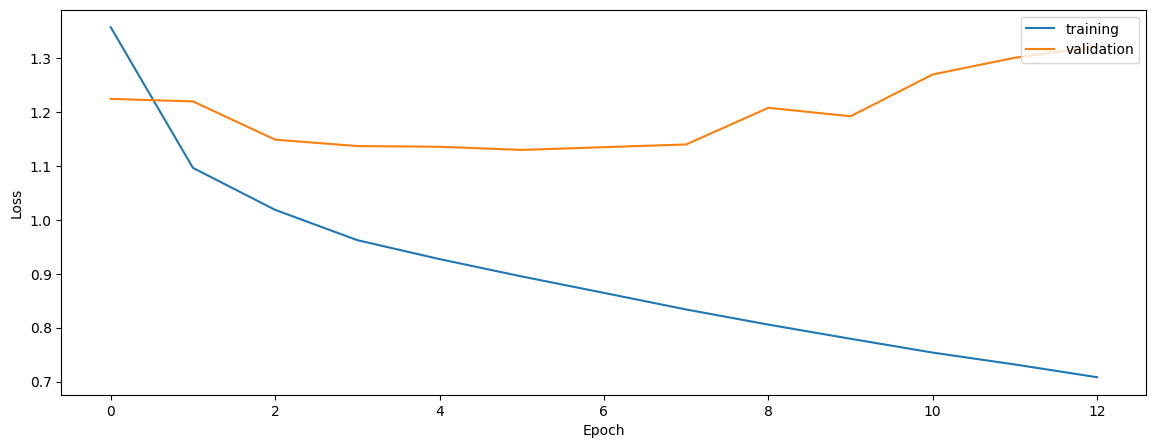

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6613118102317673
0.5542302143446002
0.6229436841498854


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6084737599817713
0.5734533027812895
0.5694624221341316


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6058507313799081
0.5823290453622207
0.5798412364514022


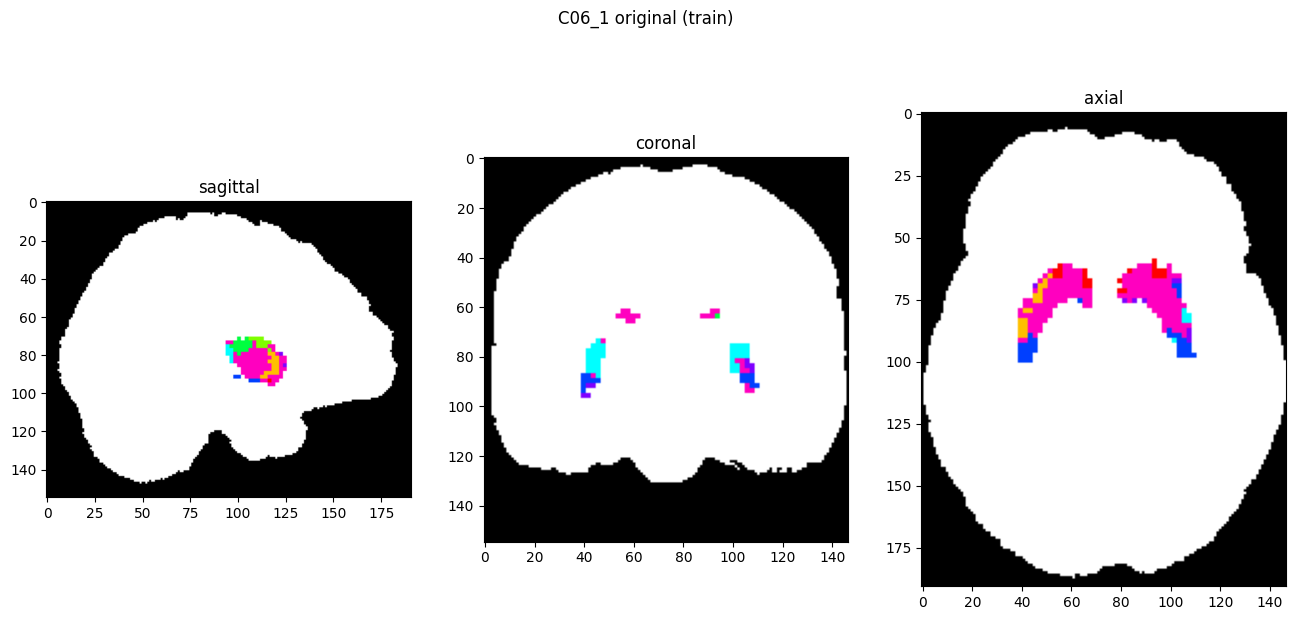

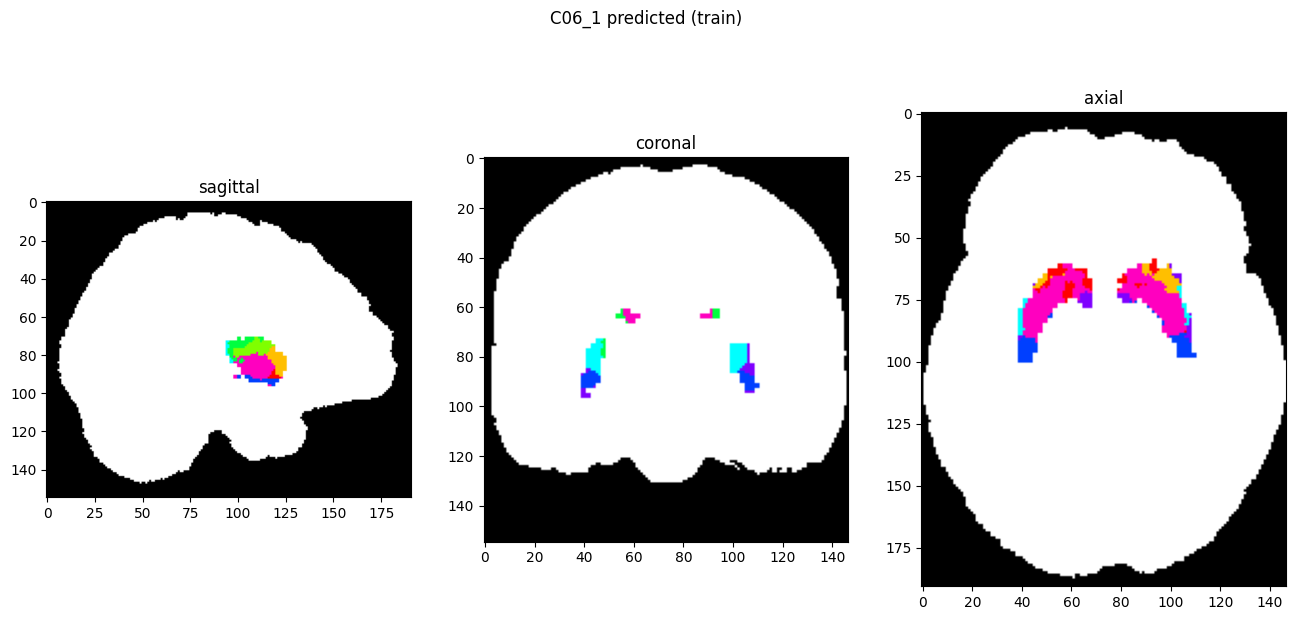

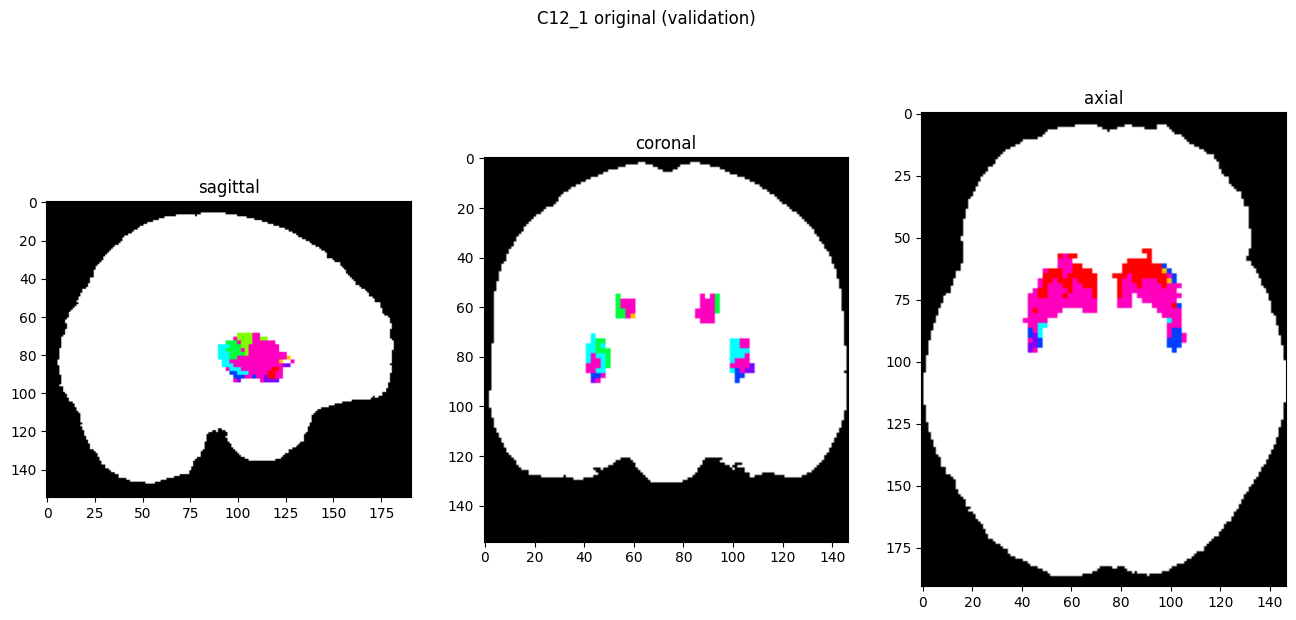

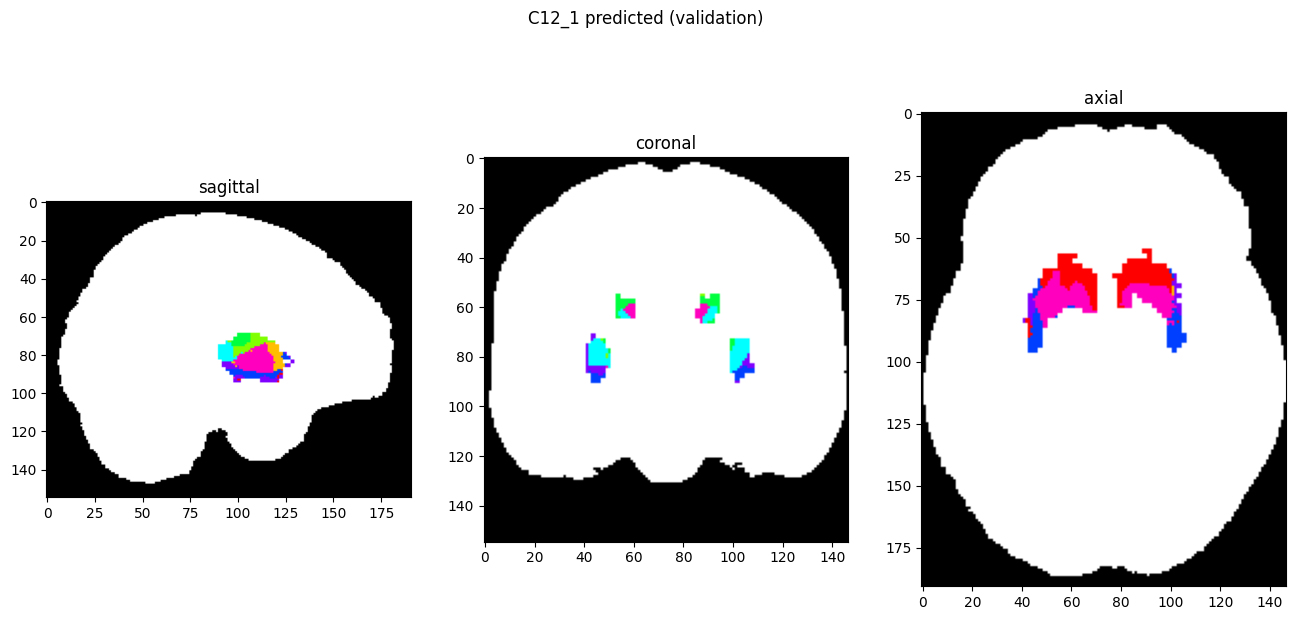

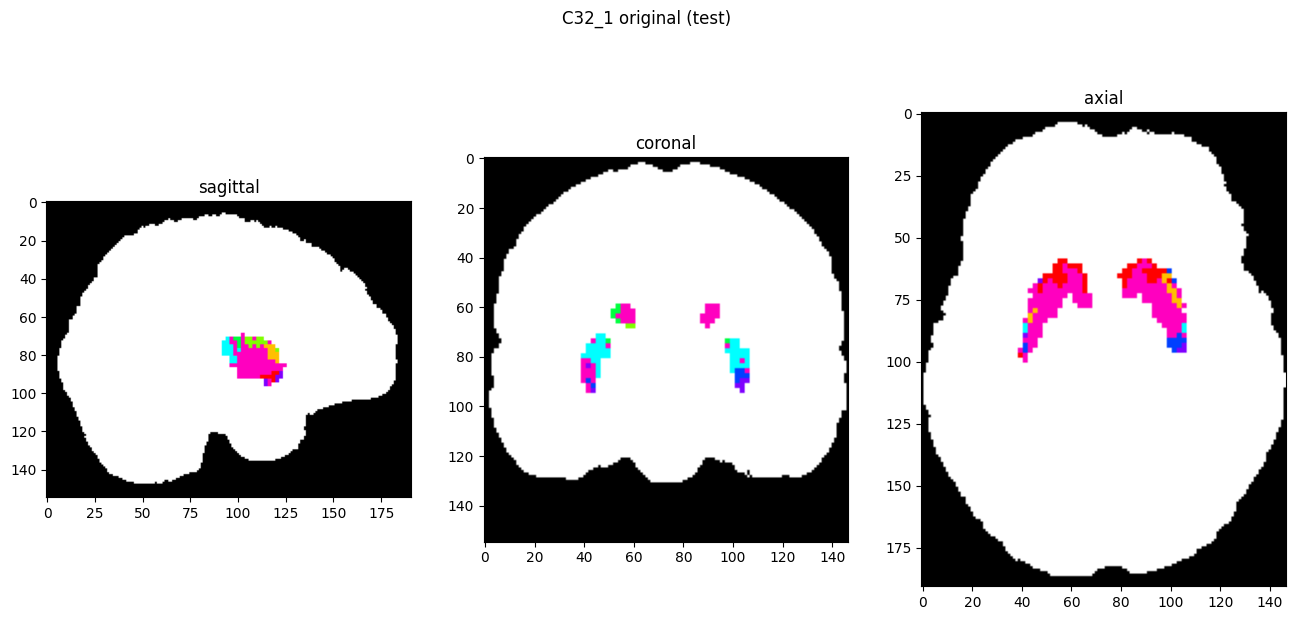

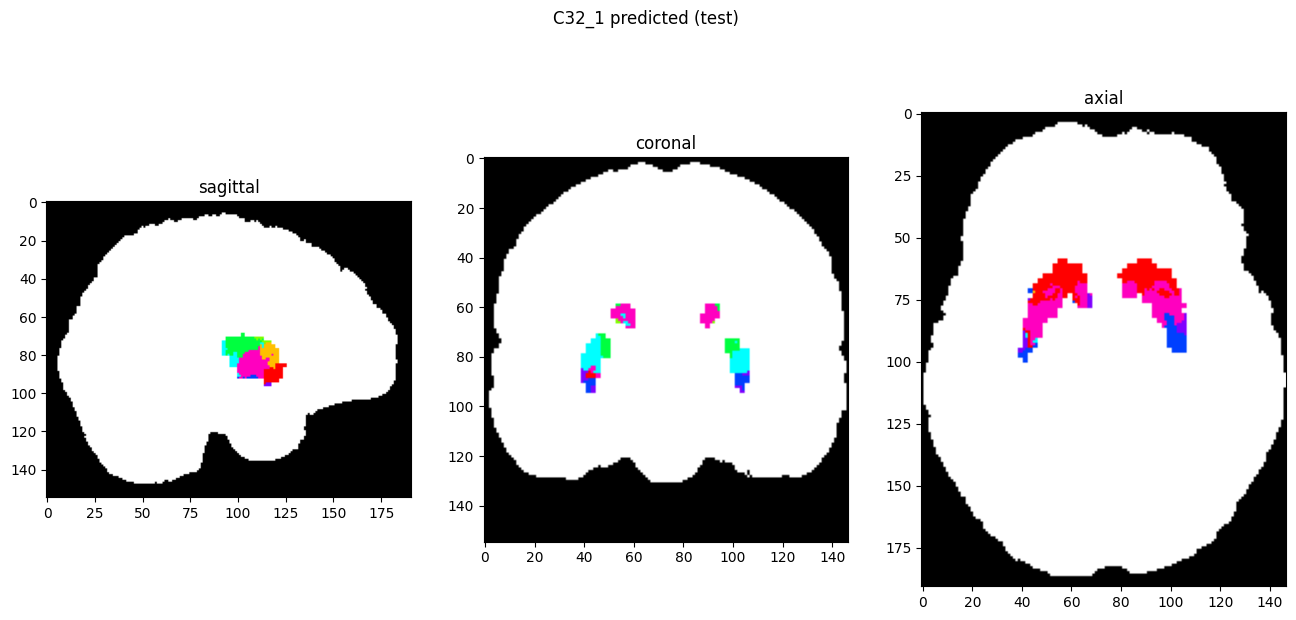

In [10]:
showResults(model, gen, threshold=0)